# Load Library

In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp
import wandb
from tqdm import tqdm

from sklearn.model_selection import train_test_split 

In [2]:
torch.__version__

'2.2.2'

In [3]:
# get the DGD modules (once the current version is public we can switch to the repo)
# git clone https://github.com/Center-for-Health-Data-Science/DeepGenerativeDecoder.git
# for now I added them to this repo, but the imports will stay the same
from base.dgd.nn import NB_Module
from base.dgd.DGD import DGD

# get the new stuff
from base.utils.helpers import set_seed
from base.model.decoder_debug import Decoder
from base.data.dataset import GeneExpressionDataset
from base.engine.train import train_dgd_mrna
from base.dgd.latent import RepresentationLayer

# Set seeds, device, and directory

In [4]:
# set random seeds, device and data directory
seed = 42
set_seed(seed)

num_workers = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

datadir = "./data/"

cpu


# Load Data

In [5]:
# tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_is.tsv", sep='\t', index_col=[0])
tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_iso.tsv", sep='\t', index_col=[0])

In [6]:
def data_filtering(df, filter_zero=True, filter_tumor=False):
    if filter_zero:
        zero_counts = (df == 0).mean()
        selected_features = zero_counts[zero_counts < 0.99].index
        df = df[selected_features]
    if filter_tumor:
        df = df[df['sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal'])]
    
    return df

tcga_mrna = data_filtering(tcga_mrna_raw)

## Data Loader

In [7]:
# shuffle the data
tcga_mrna = tcga_mrna.sample(frac=1, random_state=seed)

In [8]:
# make data split for train, validation, and test sets
train_ratio= 0.7
batch_size = 128

train_mrna, val_mrna = train_test_split(tcga_mrna, train_size=train_ratio, stratify=tcga_mrna['cancer_type']) 
val_mrna, test_mrna = train_test_split(val_mrna, test_size=0.50, stratify=val_mrna['cancer_type'])

# Train, val, and test data loaders
# Default scaling_type = "mean"
train_dataset = GeneExpressionDataset(train_mrna, scaling_type='mean')
validation_dataset = GeneExpressionDataset(val_mrna, scaling_type='mean')
test_dataset = GeneExpressionDataset(test_mrna, scaling_type='mean')

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False,
                                                num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=num_workers)

In [9]:
# make data split for train and validation sets
mrna_out_dim = tcga_mrna.shape[1]-4

In [10]:
print(train_mrna.shape)
print(val_mrna.shape)
print(test_mrna.shape)
print(mrna_out_dim)

(7473, 19745)
(1601, 19745)
(1602, 19745)
19741


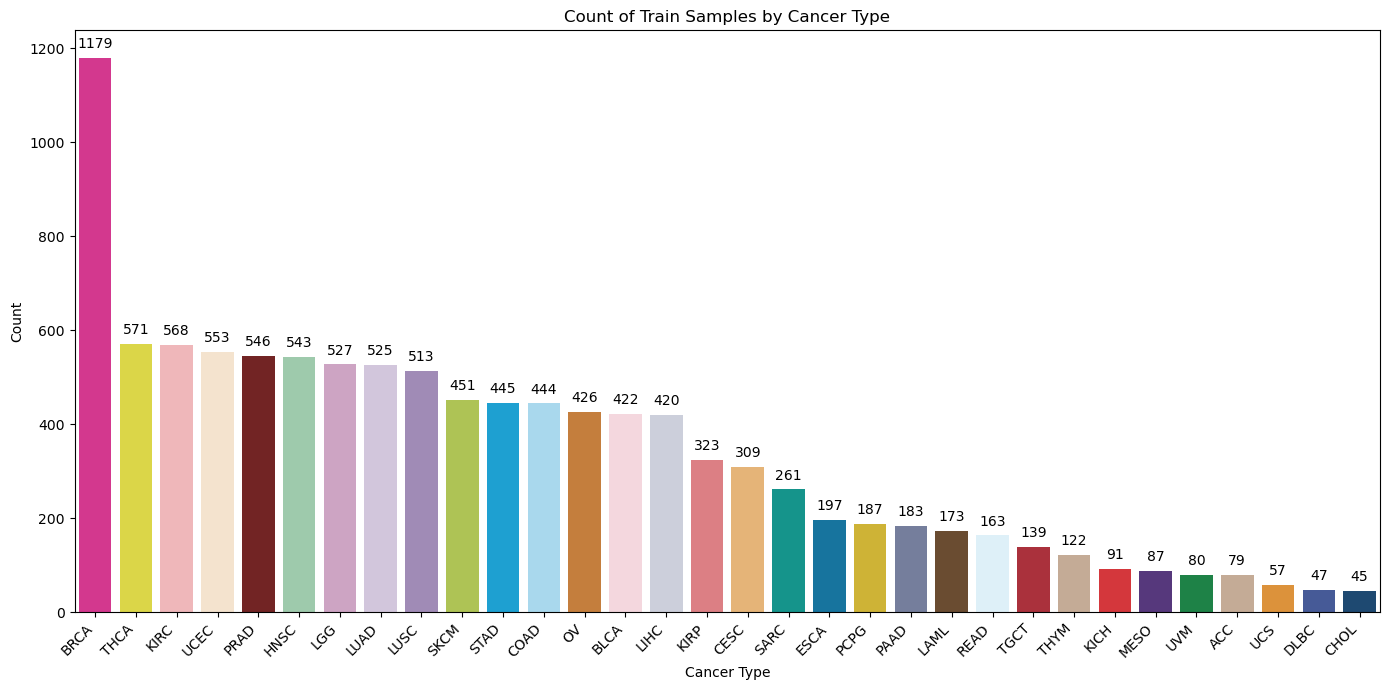

In [11]:
color_mapping = dict(zip(tcga_mrna['cancer_type'], tcga_mrna['color']))

primary_site_counts = tcga_mrna['cancer_type'].value_counts().reset_index()
primary_site_counts.columns = ['cancer_type', 'count']

# Create a bar plot
plt.figure(figsize=(14, 7))
barplot = sns.barplot(x='cancer_type', hue='cancer_type', y='count', data=primary_site_counts, palette=color_mapping)
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.title('Count of Train Samples by Cancer Type')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels to show them more clearly

# Annotate each bar with the count
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),  # Format the count as a string with no decimal places
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text at the center of the bar
                     ha='center', va='center',  # Center the text horizontally and vertically
                     xytext=(0, 10),  # Offset the text by 10 points vertically
                     textcoords='offset points')  # Use offset points for the text coordinates

plt.tight_layout()  # Adjust the layout to fit the x labels
plt.show()

# Model Setup

In [23]:
# This one is used for n GMM mixture component 
n_tissues = len(np.unique(train_dataset.label))
# n_tissues = 32

# Hyperparameters for Decoder
latent_dim = 20 # For the representation layer 
hidden_dims = [128, 128, 128] # Decoder common hidden dimension
reduction_type = "sum" # Output loss reduction, you can choose "mean". This is how you want calculate the total loss. 
activation = "relu" # ["relu", "leaky_relu"]
r_init = 2

# Hyperparameters for GMM
gmm_mean = 5.0 # usually between 2 and 10
sd_mean = 0.2 # default 0.2

In [24]:
# Output Module Setup
mrna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], mrna_out_dim)
    )
output_mrna_layer = NB_Module(mrna_out_fc, mrna_out_dim, r_init=r_init, scaling_type="mean")
output_mrna_layer.n_features = mrna_out_dim

# Set up the decoder
decoder = Decoder(latent_dim, hidden_dims, output_module=output_mrna_layer).to(device)

# Setup GMM init
gmm_mean_scale = gmm_mean # usually between 2 and 10
sd_mean_init = sd_mean * gmm_mean_scale / n_tissues # empirically good for single-cell data at dimensionality 20

In [25]:
# Init a DGD model
dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1}
)

In [26]:
dgd # sanity check

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=20, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
    )
    (out_module): NB_Module(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=19741, bias=True)
      )
    )
  )
  (gmm): GaussianMixture()
)

## Training loop

In [27]:
# Training hyperparameters
learning_rates = {'dec':1e-4,'rep':0.01,'gmm':0.01}
weight_decay = 1e-5
betas = (0.5, 0.7)

nepochs = 801
pr = 5 # how often to print epoch
plot = 400 # how often to print plot

sample_index = [1382, 1310, 34, 1371]

In [28]:
print("Hyperparameters:")
print(f"Latent dimension: {latent_dim}")
print(f"Learning rates: {learning_rates}")
print(f"Weight decay: {weight_decay}")
print(f"betas: {betas}")
print(f"Number of epochs: {nepochs}")
print(f"Hidden dimensions: {hidden_dims}")
print(f"Batch size: {batch_size}")
print(f"Reduction type: {reduction_type}")

Hyperparameters:
Latent dimension: 20
Learning rates: {'dec': 0.0001, 'rep': 0.01, 'gmm': 0.01}
Weight decay: 1e-05
betas: (0.5, 0.7)
Number of epochs: 801
Hidden dimensions: [128, 128, 128]
Batch size: 128
Reduction type: sum


# Training

  0%|                                                                                                                                     | 0/801 [00:00<?, ?it/s]

0 train_recon: 10.967172895147655 train_gmm: 9.428732653045756 train_mse: 31643824.0 train_mae: 3513.237060546875 train_r2: -0.48104381561279297 train_spearman: 0.5924094915390015 train_pearson: 0.39668747782707214 train_msle: 1.006211280822754
0 test_recon: 10.907688545426547 test_gmm: 5.033476254464983 test_mse: 22907110.0 test_mae: 3359.01318359375 test_r2: -0.6806299686431885 test_spearman: 0.6266090273857117 test_pearson: 0.49028223752975464 test_msle: 0.9776098132133484


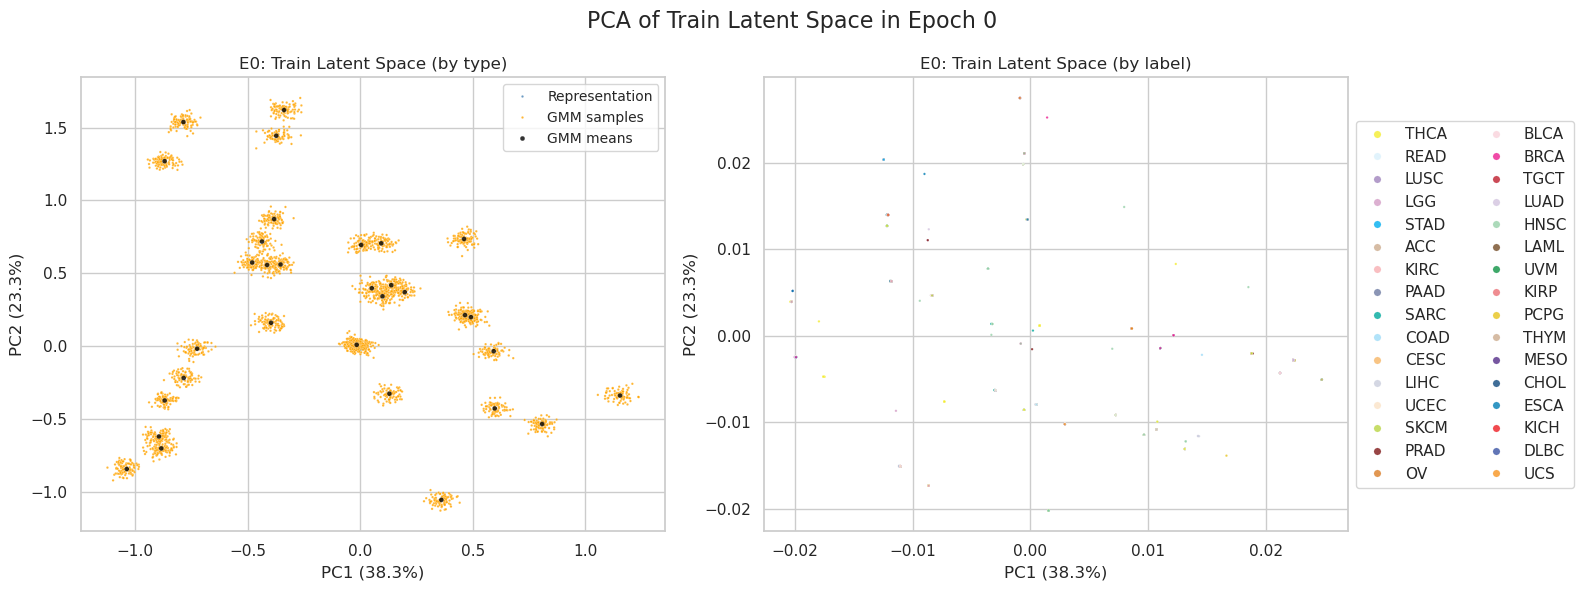

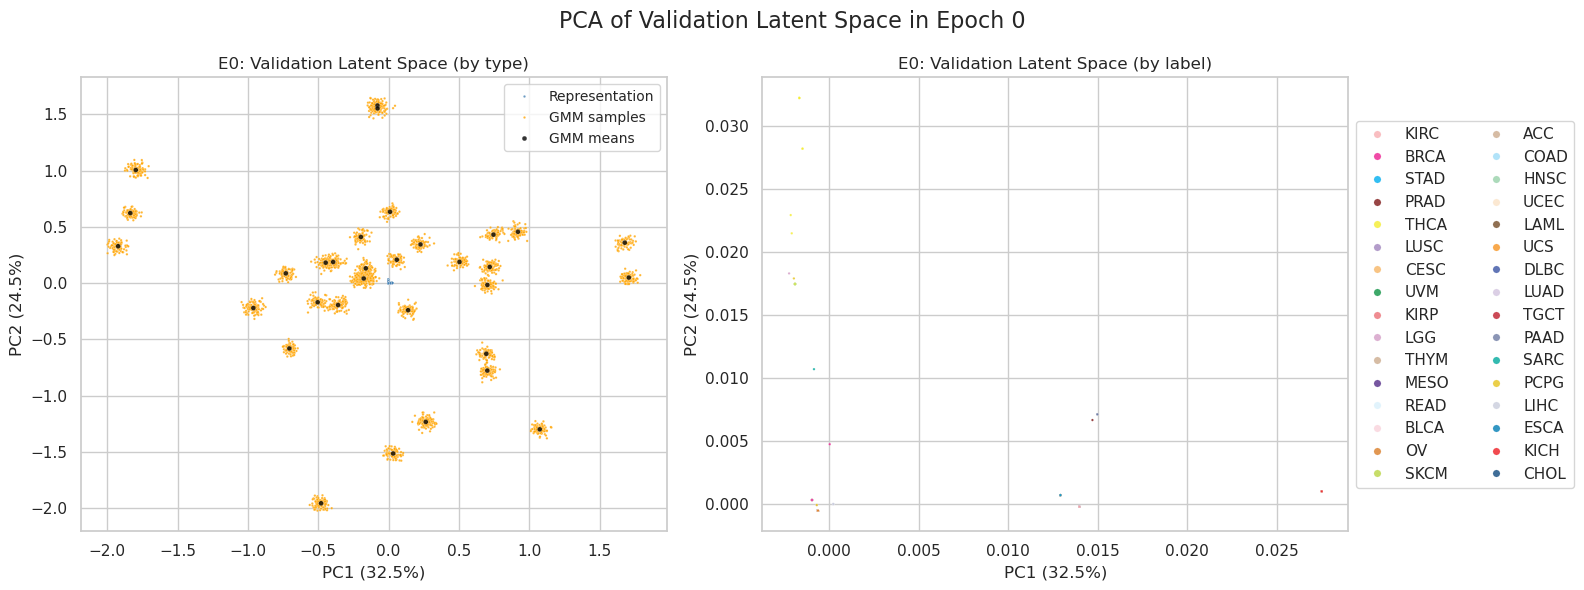

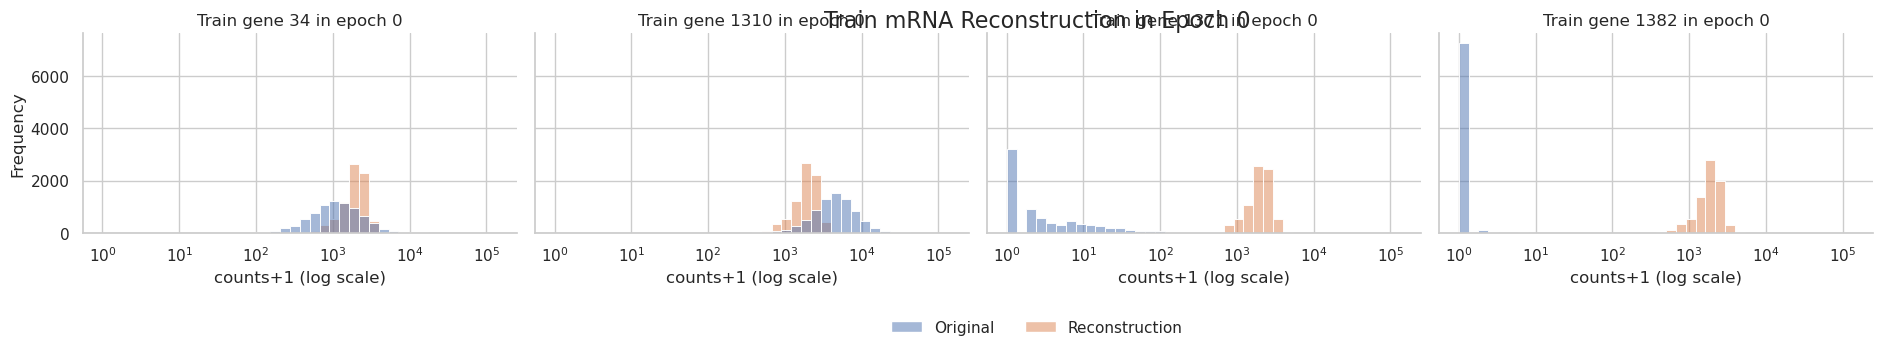

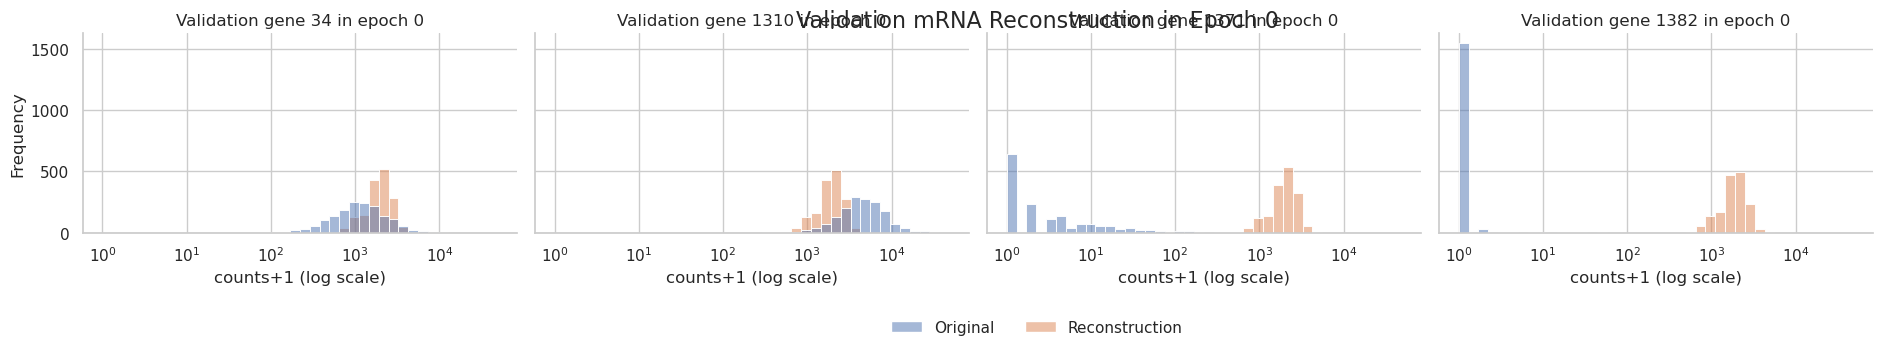

  1%|▉                                                                                                                            | 6/801 [00:25<43:57,  3.32s/it]

5 train_recon: 9.02051352923477 train_gmm: 2.1427849944043347 train_mse: 18050332.0 train_mae: 2309.193359375 train_r2: 0.15518009662628174 train_spearman: 0.5938588976860046 train_pearson: 0.3982006013393402 train_msle: 0.2839166224002838
5 test_recon: 8.713842701459857 test_gmm: 2.144169796831082 test_mse: 10533093.0 test_mae: 2143.55224609375 test_r2: 0.2272167205810547 test_spearman: 0.6300293803215027 test_pearson: 0.49290356040000916 test_msle: 0.26641204953193665


  1%|█▋                                                                                                                          | 11/801 [00:39<38:30,  2.92s/it]

10 train_recon: 7.722947639616698 train_gmm: 2.1461427676092266 train_mse: 17809196.0 train_mae: 2181.33154296875 train_r2: 0.16646605730056763 train_spearman: 0.6080760955810547 train_pearson: 0.40810588002204895 train_msle: 0.2555603086948395
10 test_recon: 7.707205437207591 test_gmm: 2.146983696712992 test_mse: 10133017.0 test_mae: 1973.672607421875 test_r2: 0.25656914710998535 test_spearman: 0.6443256139755249 test_pearson: 0.5070342421531677 test_msle: 0.23236089944839478


  2%|██▍                                                                                                                         | 16/801 [00:54<37:14,  2.85s/it]

15 train_recon: 7.668620603224171 train_gmm: 2.1470175623782075 train_mse: 17809312.0 train_mae: 2195.972412109375 train_r2: 0.16646063327789307 train_spearman: 0.6063225865364075 train_pearson: 0.4080011546611786 train_msle: 0.2584405839443207
15 test_recon: 7.6629098543818905 test_gmm: 2.14726341385755 test_mse: 10133772.0 test_mae: 1982.4716796875 test_r2: 0.256513774394989 test_spearman: 0.6431878209114075 test_pearson: 0.5074095129966736 test_msle: 0.2346821278333664


  3%|███▎                                                                                                                        | 21/801 [01:08<37:08,  2.86s/it]

20 train_recon: 7.648001003467268 train_gmm: 2.1468728617685127 train_mse: 17828542.0 train_mae: 2156.3486328125 train_r2: 0.16556060314178467 train_spearman: 0.6062946915626526 train_pearson: 0.4080139696598053 train_msle: 0.25220987200737
20 test_recon: 7.642475649922588 test_gmm: 2.147102274945347 test_mse: 10136383.0 test_mae: 1946.326416015625 test_r2: 0.2563222646713257 test_spearman: 0.6421856880187988 test_pearson: 0.5064530968666077 test_msle: 0.2289561629295349


  3%|████                                                                                                                        | 26/801 [01:22<36:34,  2.83s/it]

25 train_recon: 7.628159610079121 train_gmm: 2.1468983669988 train_mse: 17824932.0 train_mae: 2172.732177734375 train_r2: 0.1657295823097229 train_spearman: 0.6062033176422119 train_pearson: 0.40746548771858215 train_msle: 0.25491634011268616
25 test_recon: 7.622118552683864 test_gmm: 2.1468833718427938 test_mse: 10148543.0 test_mae: 1964.9693603515625 test_r2: 0.25543010234832764 test_spearman: 0.6416327953338623 test_pearson: 0.5055919289588928 test_msle: 0.23210176825523376


  4%|████▊                                                                                                                       | 31/801 [01:36<36:16,  2.83s/it]

30 train_recon: 7.590232250450778 train_gmm: 2.1484068362249933 train_mse: 17848100.0 train_mae: 2211.269775390625 train_r2: 0.16464531421661377 train_spearman: 0.6052667498588562 train_pearson: 0.40587088465690613 train_msle: 0.26202088594436646
30 test_recon: 7.579916761537235 test_gmm: 2.1490670885018153 test_mse: 10197172.0 test_mae: 2004.7705078125 test_r2: 0.2518623471260071 test_spearman: 0.6416002511978149 test_pearson: 0.5040266513824463 test_msle: 0.23925866186618805


  4%|█████▌                                                                                                                      | 36/801 [01:50<36:26,  2.86s/it]

35 train_recon: 7.506562347582513 train_gmm: 2.1515764662942845 train_mse: 17864014.0 train_mae: 2207.2236328125 train_r2: 0.1639004349708557 train_spearman: 0.5963703393936157 train_pearson: 0.4050428867340088 train_msle: 0.26236677169799805
35 test_recon: 7.494525814481799 test_gmm: 2.152224988776546 test_mse: 10198080.0 test_mae: 2006.6875 test_r2: 0.2517957091331482 test_spearman: 0.6360366940498352 test_pearson: 0.5032638907432556 test_msle: 0.2400660663843155


  5%|██████▎                                                                                                                     | 41/801 [02:05<36:01,  2.84s/it]

40 train_recon: 7.4301577399761 train_gmm: 2.152766107074008 train_mse: 17772836.0 train_mae: 2209.013671875 train_r2: 0.1681678295135498 train_spearman: 0.5944334268569946 train_pearson: 0.4101862609386444 train_msle: 0.26092198491096497
40 test_recon: 7.420472476471619 test_gmm: 2.153182825187383 test_mse: 10113673.0 test_mae: 2006.371826171875 test_r2: 0.2579883933067322 test_spearman: 0.6334811449050903 test_pearson: 0.5088998675346375 test_msle: 0.23776794970035553


  6%|███████                                                                                                                     | 46/801 [02:19<35:45,  2.84s/it]

45 train_recon: 7.36961761325965 train_gmm: 2.153315820417043 train_mse: 17624864.0 train_mae: 2163.336181640625 train_r2: 0.17509347200393677 train_spearman: 0.6076986789703369 train_pearson: 0.4193170368671417 train_msle: 0.24982419610023499
45 test_recon: 7.360123562659868 test_gmm: 2.1537058899955106 test_mse: 9994790.0 test_mae: 1964.6971435546875 test_r2: 0.26671046018600464 test_spearman: 0.6469962000846863 test_pearson: 0.5165743231773376 test_msle: 0.2269282191991806


  6%|███████▉                                                                                                                    | 51/801 [02:33<35:28,  2.84s/it]

50 train_recon: 7.315503446603948 train_gmm: 2.15409374464217 train_mse: 17749868.0 train_mae: 2202.32861328125 train_r2: 0.16924279928207397 train_spearman: 0.6100320219993591 train_pearson: 0.4116576313972473 train_msle: 0.25493869185447693
50 test_recon: 7.308214076854921 test_gmm: 2.1544949781142644 test_mse: 10079171.0 test_mae: 2002.4090576171875 test_r2: 0.26051968336105347 test_spearman: 0.6508429646492004 test_pearson: 0.5120312571525574 test_msle: 0.23104766011238098


  7%|████████▋                                                                                                                   | 56/801 [02:47<35:15,  2.84s/it]

55 train_recon: 7.276232950687043 train_gmm: 2.155527361064938 train_mse: 17806472.0 train_mae: 2203.1689453125 train_r2: 0.16659361124038696 train_spearman: 0.606582522392273 train_pearson: 0.4086836278438568 train_msle: 0.25497034192085266
55 test_recon: 7.270169810855704 test_gmm: 2.156035450560685 test_mse: 10132676.0 test_mae: 2002.649169921875 test_r2: 0.2565942406654358 test_spearman: 0.6457491517066956 test_pearson: 0.5080344080924988 test_msle: 0.23124995827674866


  8%|█████████▍                                                                                                                  | 61/801 [03:01<35:01,  2.84s/it]

60 train_recon: 7.235785870485927 train_gmm: 2.158076382921225 train_mse: 17815472.0 train_mae: 2194.5595703125 train_r2: 0.16617238521575928 train_spearman: 0.6048246026039124 train_pearson: 0.40838178992271423 train_msle: 0.25355294346809387
60 test_recon: 7.229591795892979 test_gmm: 2.158553598702959 test_mse: 10151763.0 test_mae: 2000.2025146484375 test_r2: 0.255193829536438 test_spearman: 0.6412487626075745 test_pearson: 0.5064648985862732 test_msle: 0.23138582706451416


  8%|██████████▏                                                                                                                 | 66/801 [03:16<34:49,  2.84s/it]

65 train_recon: 7.192097921665116 train_gmm: 2.160145647050737 train_mse: 17641572.0 train_mae: 2164.93017578125 train_r2: 0.17431151866912842 train_spearman: 0.6097132563591003 train_pearson: 0.4182121455669403 train_msle: 0.24964042007923126
65 test_recon: 7.185783567404003 test_gmm: 2.1613114575607044 test_mse: 10046478.0 test_mae: 1978.0762939453125 test_r2: 0.26291829347610474 test_spearman: 0.6417244076728821 test_pearson: 0.5129045248031616 test_msle: 0.2290288805961609


  9%|██████████▉                                                                                                                 | 71/801 [03:30<34:30,  2.84s/it]

70 train_recon: 7.152306698657829 train_gmm: 2.1621450029350453 train_mse: 17300284.0 train_mae: 2144.071533203125 train_r2: 0.19028502702713013 train_spearman: 0.6127304434776306 train_pearson: 0.43745100498199463 train_msle: 0.24736590683460236
70 test_recon: 7.146345201591085 test_gmm: 2.16323861307386 test_mse: 9859578.0 test_mae: 1980.1162109375 test_r2: 0.27663058042526245 test_spearman: 0.6367220878601074 test_pearson: 0.526120126247406 test_msle: 0.23107853531837463


  9%|███████████▊                                                                                                                | 76/801 [03:45<34:55,  2.89s/it]

75 train_recon: 7.117368662978561 train_gmm: 2.1639881339750184 train_mse: 16986564.0 train_mae: 2139.8037109375 train_r2: 0.20496821403503418 train_spearman: 0.6186617612838745 train_pearson: 0.4537426233291626 train_msle: 0.24640263617038727
75 test_recon: 7.111485618838917 test_gmm: 2.1645796480959167 test_mse: 9648895.0 test_mae: 1968.8514404296875 test_r2: 0.2920878529548645 test_spearman: 0.6420196890830994 test_pearson: 0.5410760641098022 test_msle: 0.2297745794057846


 10%|████████████▌                                                                                                               | 81/801 [03:59<34:18,  2.86s/it]

80 train_recon: 7.08334933237154 train_gmm: 2.165486039455582 train_mse: 16655106.0 train_mae: 2089.199462890625 train_r2: 0.22048163414001465 train_spearman: 0.6353852152824402 train_pearson: 0.47219857573509216 train_msle: 0.23860619962215424
80 test_recon: 7.077695633785441 test_gmm: 2.166539924998048 test_mse: 9339645.0 test_mae: 1914.335205078125 test_r2: 0.31477659940719604 test_spearman: 0.659740149974823 test_pearson: 0.5621570348739624 test_msle: 0.22056829929351807


 11%|█████████████▎                                                                                                              | 86/801 [04:13<33:54,  2.85s/it]

85 train_recon: 7.0501716620032715 train_gmm: 2.1667582626883863 train_mse: 16300691.0 train_mae: 2017.5577392578125 train_r2: 0.2370694875717163 train_spearman: 0.6529262661933899 train_pearson: 0.49345192313194275 train_msle: 0.22895583510398865
85 test_recon: 7.044521525649731 test_gmm: 2.1681407311348377 test_mse: 9020397.0 test_mae: 1855.7783203125 test_r2: 0.3381989598274231 test_spearman: 0.6749557256698608 test_pearson: 0.5843116044998169 test_msle: 0.2124619334936142


 11%|██████████████                                                                                                              | 91/801 [04:27<33:44,  2.85s/it]

90 train_recon: 7.018310112070679 train_gmm: 2.1677939704028253 train_mse: 15960323.0 train_mae: 1970.3475341796875 train_r2: 0.2529999613761902 train_spearman: 0.6619718074798584 train_pearson: 0.5126054883003235 train_msle: 0.22285617887973785
90 test_recon: 7.012997201960264 test_gmm: 2.1688072457155685 test_mse: 8803257.0 test_mae: 1811.026611328125 test_r2: 0.3541299104690552 test_spearman: 0.6798030734062195 test_pearson: 0.5997385382652283 test_msle: 0.20590724050998688


 12%|██████████████▊                                                                                                             | 96/801 [04:42<33:15,  2.83s/it]

95 train_recon: 6.98778500123366 train_gmm: 2.169351984853807 train_mse: 15722253.0 train_mae: 1960.4049072265625 train_r2: 0.2641424536705017 train_spearman: 0.6681931614875793 train_pearson: 0.5218467712402344 train_msle: 0.22128620743751526
95 test_recon: 6.983016193370608 test_gmm: 2.170417064163999 test_mse: 8580996.0 test_mae: 1796.1744384765625 test_r2: 0.3704366087913513 test_spearman: 0.6874386072158813 test_pearson: 0.612411379814148 test_msle: 0.20383280515670776


 13%|███████████████▌                                                                                                           | 101/801 [04:56<33:17,  2.85s/it]

100 train_recon: 6.958994077003878 train_gmm: 2.171907962087996 train_mse: 15540031.0 train_mae: 1928.5921630859375 train_r2: 0.272671103477478 train_spearman: 0.6722201704978943 train_pearson: 0.5326255559921265 train_msle: 0.21499773859977722
100 test_recon: 6.954493419324285 test_gmm: 2.172951925493344 test_mse: 8500363.0 test_mae: 1778.900390625 test_r2: 0.37635236978530884 test_spearman: 0.6865803003311157 test_pearson: 0.6171059012413025 test_msle: 0.20075508952140808


 13%|████████████████▎                                                                                                          | 106/801 [05:10<32:53,  2.84s/it]

105 train_recon: 6.931049164832581 train_gmm: 2.1756863772079487 train_mse: 15408093.0 train_mae: 1921.1536865234375 train_r2: 0.27884626388549805 train_spearman: 0.6766283512115479 train_pearson: 0.5364910960197449 train_msle: 0.21302859485149384
105 test_recon: 6.927196134349571 test_gmm: 2.1767892869690817 test_mse: 8388514.5 test_mae: 1771.4283447265625 test_r2: 0.38455837965011597 test_spearman: 0.6926083564758301 test_pearson: 0.6224167943000793 test_msle: 0.19878485798835754


 14%|█████████████████                                                                                                          | 111/801 [05:24<32:55,  2.86s/it]

110 train_recon: 6.902913152190938 train_gmm: 2.1809413203940435 train_mse: 15285592.0 train_mae: 1915.93359375 train_r2: 0.2845797538757324 train_spearman: 0.6800875067710876 train_pearson: 0.5406978726387024 train_msle: 0.21036259829998016
110 test_recon: 6.898318705056845 test_gmm: 2.182305279171221 test_mse: 8312372.5 test_mae: 1760.573486328125 test_r2: 0.3901447057723999 test_spearman: 0.6956678628921509 test_pearson: 0.6267343163490295 test_msle: 0.19591379165649414


 14%|█████████████████▊                                                                                                         | 116/801 [05:38<32:22,  2.84s/it]

115 train_recon: 6.874811011890751 train_gmm: 2.187036292894002 train_mse: 15082183.0 train_mae: 1916.91943359375 train_r2: 0.2941000461578369 train_spearman: 0.6839814782142639 train_pearson: 0.5469693541526794 train_msle: 0.20912574231624603
115 test_recon: 6.869660415940458 test_gmm: 2.1892079626746956 test_mse: 8196811.0 test_mae: 1763.2115478515625 test_r2: 0.39862316846847534 test_spearman: 0.6985536813735962 test_pearson: 0.6326245665550232 test_msle: 0.19496086239814758


 15%|██████████████████▌                                                                                                        | 121/801 [05:53<32:24,  2.86s/it]

120 train_recon: 6.848670159469723 train_gmm: 2.194060154642651 train_mse: 14843178.0 train_mae: 1888.4979248046875 train_r2: 0.30528634786605835 train_spearman: 0.690889835357666 train_pearson: 0.5581260323524475 train_msle: 0.2027224898338318
120 test_recon: 6.84333970641228 test_gmm: 2.1963204683474196 test_mse: 7987608.5 test_mae: 1738.5506591796875 test_r2: 0.4139717221260071 test_spearman: 0.7062997221946716 test_pearson: 0.6450662016868591 test_msle: 0.18927204608917236


 16%|███████████████████▎                                                                                                       | 126/801 [06:07<31:39,  2.81s/it]

125 train_recon: 6.82503834126039 train_gmm: 2.2002028428645204 train_mse: 14612226.0 train_mae: 1874.335205078125 train_r2: 0.31609565019607544 train_spearman: 0.6980770826339722 train_pearson: 0.5679168701171875 train_msle: 0.19942606985569
125 test_recon: 6.819671966203434 test_gmm: 2.2017044400960337 test_mse: 7781771.0 test_mae: 1729.5303955078125 test_r2: 0.4290734529495239 test_spearman: 0.7128079533576965 test_pearson: 0.6569229364395142 test_msle: 0.18572112917900085


 16%|████████████████████                                                                                                       | 131/801 [06:21<31:38,  2.83s/it]

130 train_recon: 6.80303466963957 train_gmm: 2.2050503933300507 train_mse: 14428934.0 train_mae: 1855.310791015625 train_r2: 0.32467442750930786 train_spearman: 0.7044486403465271 train_pearson: 0.5755036473274231 train_msle: 0.19483651220798492
130 test_recon: 6.798248625129531 test_gmm: 2.207907556251464 test_mse: 7644133.0 test_mae: 1706.2222900390625 test_r2: 0.43917155265808105 test_spearman: 0.7203173041343689 test_pearson: 0.664890468120575 test_msle: 0.18094049394130707


 17%|████████████████████▉                                                                                                      | 136/801 [06:36<31:44,  2.86s/it]

135 train_recon: 6.782606017835967 train_gmm: 2.20990225292825 train_mse: 14231241.0 train_mae: 1838.240234375 train_r2: 0.3339271545410156 train_spearman: 0.7098824381828308 train_pearson: 0.5837080478668213 train_msle: 0.19142097234725952
135 test_recon: 6.777951486111161 test_gmm: 2.2120150659621918 test_mse: 7507118.5 test_mae: 1694.5791015625 test_r2: 0.44922393560409546 test_spearman: 0.7263380289077759 test_pearson: 0.6720213890075684 test_msle: 0.17890746891498566


 18%|█████████████████████▋                                                                                                     | 141/801 [06:50<31:19,  2.85s/it]

140 train_recon: 6.763638370883945 train_gmm: 2.214113418985431 train_mse: 14062779.0 train_mae: 1819.9913330078125 train_r2: 0.34181177616119385 train_spearman: 0.7125129103660583 train_pearson: 0.591390073299408 train_msle: 0.18781980872154236
140 test_recon: 6.759575984324928 test_gmm: 2.2161075780274047 test_mse: 7449654.5 test_mae: 1682.4188232421875 test_r2: 0.4534398913383484 test_spearman: 0.7266269326210022 test_pearson: 0.6749812364578247 test_msle: 0.1760351061820984


 18%|██████████████████████▍                                                                                                    | 146/801 [07:04<31:11,  2.86s/it]

145 train_recon: 6.746040076206193 train_gmm: 2.2177393858777013 train_mse: 13870950.0 train_mae: 1817.5145263671875 train_r2: 0.3507900834083557 train_spearman: 0.7160248756408691 train_pearson: 0.5979433059692383 train_msle: 0.18706361949443817
145 test_recon: 6.7422176523898285 test_gmm: 2.219345094679595 test_mse: 7408335.0 test_mae: 1683.194580078125 test_r2: 0.45647138357162476 test_spearman: 0.7276349067687988 test_pearson: 0.6766022443771362 test_msle: 0.17618872225284576


 19%|███████████████████████▏                                                                                                   | 151/801 [07:18<30:55,  2.85s/it]

150 train_recon: 6.72969636980891 train_gmm: 2.220690243339564 train_mse: 13722502.0 train_mae: 1801.6630859375 train_r2: 0.3577379584312439 train_spearman: 0.7179759740829468 train_pearson: 0.6044389009475708 train_msle: 0.18393957614898682
150 test_recon: 6.7259905849457535 test_gmm: 2.2220542550310354 test_mse: 7305567.5 test_mae: 1675.166015625 test_r2: 0.46401113271713257 test_spearman: 0.73143070936203 test_pearson: 0.6818171143531799 test_msle: 0.17409572005271912


 19%|███████████████████████▉                                                                                                   | 156/801 [07:33<30:46,  2.86s/it]

155 train_recon: 6.714491718334528 train_gmm: 2.2240358944544107 train_mse: 13605900.0 train_mae: 1808.709716796875 train_r2: 0.36319535970687866 train_spearman: 0.7198072671890259 train_pearson: 0.6074167490005493 train_msle: 0.18446193635463715
155 test_recon: 6.711627221487659 test_gmm: 2.2252325969364852 test_mse: 7254333.5 test_mae: 1670.3841552734375 test_r2: 0.4677700400352478 test_spearman: 0.7330695390701294 test_pearson: 0.6844884157180786 test_msle: 0.17312750220298767


 20%|████████████████████████▋                                                                                                  | 161/801 [07:47<30:48,  2.89s/it]

160 train_recon: 6.700154468587125 train_gmm: 2.226807271150099 train_mse: 13469143.0 train_mae: 1799.6234130859375 train_r2: 0.36959606409072876 train_spearman: 0.7238165736198425 train_pearson: 0.6130788326263428 train_msle: 0.18189243972301483
160 test_recon: 6.696963529044031 test_gmm: 2.2273687892820893 test_mse: 7186588.5 test_mae: 1660.6842041015625 test_r2: 0.4727402925491333 test_spearman: 0.7357951998710632 test_pearson: 0.6881296038627625 test_msle: 0.17124982178211212


 21%|█████████████████████████▍                                                                                                 | 166/801 [08:01<30:07,  2.85s/it]

165 train_recon: 6.686693795314382 train_gmm: 2.230008497714167 train_mse: 13392347.0 train_mae: 1788.2530517578125 train_r2: 0.37319034337997437 train_spearman: 0.7269130945205688 train_pearson: 0.6165019273757935 train_msle: 0.178781658411026
165 test_recon: 6.684849627156372 test_gmm: 2.2299283620344705 test_mse: 7127101.5 test_mae: 1654.458984375 test_r2: 0.47710466384887695 test_spearman: 0.7384744882583618 test_pearson: 0.6911187767982483 test_msle: 0.1698218435049057


 21%|██████████████████████████▎                                                                                                | 171/801 [08:16<29:47,  2.84s/it]

170 train_recon: 6.673957706806015 train_gmm: 2.233409692209663 train_mse: 13270360.0 train_mae: 1786.6561279296875 train_r2: 0.37889981269836426 train_spearman: 0.7300881147384644 train_pearson: 0.6205284595489502 train_msle: 0.17747144401073456
170 test_recon: 6.671609016969632 test_gmm: 2.232898871798876 test_mse: 7071074.0 test_mae: 1641.0709228515625 test_r2: 0.48121529817581177 test_spearman: 0.7428841590881348 test_pearson: 0.6943753361701965 test_msle: 0.16661009192466736


 22%|███████████████████████████                                                                                                | 176/801 [08:30<29:43,  2.85s/it]

175 train_recon: 6.6618830982866015 train_gmm: 2.2367374468660093 train_mse: 13186936.0 train_mae: 1778.3665771484375 train_r2: 0.38280433416366577 train_spearman: 0.7347649335861206 train_pearson: 0.6238507628440857 train_msle: 0.1747966706752777
175 test_recon: 6.65956364780244 test_gmm: 2.2358274994754255 test_mse: 7021003.0 test_mae: 1638.2152099609375 test_r2: 0.48488885164260864 test_spearman: 0.7464547753334045 test_pearson: 0.696742057800293 test_msle: 0.16522662341594696


 23%|███████████████████████████▊                                                                                               | 181/801 [08:44<29:20,  2.84s/it]

180 train_recon: 6.650565665729825 train_gmm: 2.239379170613166 train_mse: 13086790.0 train_mae: 1770.5299072265625 train_r2: 0.38749152421951294 train_spearman: 0.7394696474075317 train_pearson: 0.6275349855422974 train_msle: 0.1718473732471466
180 test_recon: 6.648973823759724 test_gmm: 2.2389337657616335 test_mse: 7001169.5 test_mae: 1625.5440673828125 test_r2: 0.48634397983551025 test_spearman: 0.7499491572380066 test_pearson: 0.6978499293327332 test_msle: 0.16232173144817352


 23%|████████████████████████████▌                                                                                              | 186/801 [08:58<29:02,  2.83s/it]

185 train_recon: 6.639905676544165 train_gmm: 2.2416648959692393 train_mse: 13021142.0 train_mae: 1765.0035400390625 train_r2: 0.39056408405303955 train_spearman: 0.7433228492736816 train_pearson: 0.6301554441452026 train_msle: 0.16969740390777588
185 test_recon: 6.638584124120034 test_gmm: 2.2400645058874336 test_mse: 7000491.5 test_mae: 1630.6016845703125 test_r2: 0.48639369010925293 test_spearman: 0.7526019811630249 test_pearson: 0.6975229382514954 test_msle: 0.16226157546043396


 24%|█████████████████████████████▎                                                                                             | 191/801 [09:13<29:07,  2.86s/it]

190 train_recon: 6.62980131034919 train_gmm: 2.2436068561012354 train_mse: 12955533.0 train_mae: 1755.576416015625 train_r2: 0.3936348557472229 train_spearman: 0.7466740608215332 train_pearson: 0.6326013207435608 train_msle: 0.1674213409423828
190 test_recon: 6.629292814780894 test_gmm: 2.242442421850601 test_mse: 6921579.5 test_mae: 1614.8905029296875 test_r2: 0.49218326807022095 test_spearman: 0.7566841840744019 test_pearson: 0.7018274068832397 test_msle: 0.15854805707931519


 24%|██████████████████████████████                                                                                             | 196/801 [09:27<28:53,  2.87s/it]

195 train_recon: 6.620245249715923 train_gmm: 2.2457025565473203 train_mse: 12895148.0 train_mae: 1755.3092041015625 train_r2: 0.3964610695838928 train_spearman: 0.7499603033065796 train_pearson: 0.6340433359146118 train_msle: 0.16637574136257172
195 test_recon: 6.619510101156637 test_gmm: 2.24452152097322 test_mse: 6891448.5 test_mae: 1606.7178955078125 test_r2: 0.49439388513565063 test_spearman: 0.7601953148841858 test_pearson: 0.7032738924026489 test_msle: 0.15676414966583252


 25%|██████████████████████████████▊                                                                                            | 201/801 [09:41<28:21,  2.84s/it]

200 train_recon: 6.611079483594633 train_gmm: 2.247275233157074 train_mse: 12857304.0 train_mae: 1744.03173828125 train_r2: 0.39823228120803833 train_spearman: 0.7526960372924805 train_pearson: 0.6360041499137878 train_msle: 0.16370394825935364
200 test_recon: 6.610407968703771 test_gmm: 2.245873207602182 test_mse: 6864780.0 test_mae: 1603.296142578125 test_r2: 0.4963505268096924 test_spearman: 0.7617979049682617 test_pearson: 0.704635500907898 test_msle: 0.15586203336715698


 26%|███████████████████████████████▋                                                                                           | 206/801 [09:55<28:05,  2.83s/it]

205 train_recon: 6.602213549040972 train_gmm: 2.248785481248118 train_mse: 12806595.0 train_mae: 1734.1051025390625 train_r2: 0.4006056785583496 train_spearman: 0.7554001212120056 train_pearson: 0.6384137272834778 train_msle: 0.16147370636463165
205 test_recon: 6.60187621452969 test_gmm: 2.247493799651585 test_mse: 6809106.5 test_mae: 1595.9959716796875 test_r2: 0.5004351139068604 test_spearman: 0.7639358043670654 test_pearson: 0.7074909806251526 test_msle: 0.15450532734394073


 26%|████████████████████████████████▍                                                                                          | 211/801 [10:10<28:02,  2.85s/it]

210 train_recon: 6.593723443604717 train_gmm: 2.2502973562899355 train_mse: 12756565.0 train_mae: 1734.0072021484375 train_r2: 0.40294724702835083 train_spearman: 0.7582637667655945 train_pearson: 0.6397889852523804 train_msle: 0.16099804639816284
210 test_recon: 6.5942666146206115 test_gmm: 2.249495417292903 test_mse: 6770260.5 test_mae: 1588.06005859375 test_r2: 0.5032851696014404 test_spearman: 0.7657473683357239 test_pearson: 0.7096278071403503 test_msle: 0.15282048285007477


 27%|█████████████████████████████████▏                                                                                         | 216/801 [10:24<27:42,  2.84s/it]

215 train_recon: 6.585441259574435 train_gmm: 2.25197074049913 train_mse: 12706924.0 train_mae: 1728.798828125 train_r2: 0.40527063608169556 train_spearman: 0.7605029940605164 train_pearson: 0.6413464546203613 train_msle: 0.15948568284511566
215 test_recon: 6.586311661690345 test_gmm: 2.24993896484375 test_mse: 6747921.0 test_mae: 1586.724609375 test_r2: 0.5049240589141846 test_spearman: 0.7674155235290527 test_pearson: 0.7106805443763733 test_msle: 0.15200109779834747


 28%|█████████████████████████████████▉                                                                                         | 221/801 [10:38<27:33,  2.85s/it]

220 train_recon: 6.577489461360155 train_gmm: 2.253759125298993 train_mse: 12648844.0 train_mae: 1727.15771484375 train_r2: 0.407988965511322 train_spearman: 0.7626878619194031 train_pearson: 0.6429606080055237 train_msle: 0.15885703265666962
220 test_recon: 6.577841400287375 test_gmm: 2.252474939368949 test_mse: 6699369.0 test_mae: 1574.861083984375 test_r2: 0.5084862112998962 test_spearman: 0.7697058320045471 test_pearson: 0.7134240865707397 test_msle: 0.1498781442642212


 28%|██████████████████████████████████▋                                                                                        | 226/801 [10:52<27:07,  2.83s/it]

225 train_recon: 6.56967548432788 train_gmm: 2.2557076030349883 train_mse: 12579292.0 train_mae: 1719.786376953125 train_r2: 0.41124427318573 train_spearman: 0.7649076581001282 train_pearson: 0.6458267569541931 train_msle: 0.1574697196483612
225 test_recon: 6.570739230435767 test_gmm: 2.254367082585103 test_mse: 6688276.5 test_mae: 1575.789306640625 test_r2: 0.5093000531196594 test_spearman: 0.7720621228218079 test_pearson: 0.7137045860290527 test_msle: 0.1495358794927597


 29%|███████████████████████████████████▍                                                                                       | 231/801 [11:06<27:03,  2.85s/it]

230 train_recon: 6.562018359215781 train_gmm: 2.257908762887541 train_mse: 12540365.0 train_mae: 1716.6422119140625 train_r2: 0.41306614875793457 train_spearman: 0.7671507596969604 train_pearson: 0.6469818949699402 train_msle: 0.1564839780330658
230 test_recon: 6.56343424676228 test_gmm: 2.255962886965178 test_mse: 6630248.5 test_mae: 1566.140869140625 test_r2: 0.5135573744773865 test_spearman: 0.7733972668647766 test_pearson: 0.7168165445327759 test_msle: 0.14843763411045074


 29%|████████████████████████████████████▏                                                                                      | 236/801 [11:21<26:48,  2.85s/it]

235 train_recon: 6.554637977979697 train_gmm: 2.260070397310526 train_mse: 12524538.0 train_mae: 1704.451171875 train_r2: 0.4138069152832031 train_spearman: 0.7681819796562195 train_pearson: 0.648685872554779 train_msle: 0.15435731410980225
235 test_recon: 6.556505307125147 test_gmm: 2.2582734698284277 test_mse: 6621770.0 test_mae: 1551.4476318359375 test_r2: 0.5141794681549072 test_spearman: 0.7763558030128479 test_pearson: 0.7178031802177429 test_msle: 0.1457788199186325


 30%|█████████████████████████████████████                                                                                      | 241/801 [11:35<26:55,  2.88s/it]

240 train_recon: 6.547252465392306 train_gmm: 2.2621398035532083 train_mse: 12463084.0 train_mae: 1702.509765625 train_r2: 0.4166831970214844 train_spearman: 0.7713729739189148 train_pearson: 0.6505545973777771 train_msle: 0.15362724661827087
240 test_recon: 6.549321552961571 test_gmm: 2.2602833754416185 test_mse: 6589839.5 test_mae: 1549.4320068359375 test_r2: 0.5165221095085144 test_spearman: 0.7783639430999756 test_pearson: 0.7191300392150879 test_msle: 0.14511418342590332


 31%|█████████████████████████████████████▊                                                                                     | 246/801 [11:49<26:33,  2.87s/it]

245 train_recon: 6.540061218851299 train_gmm: 2.2639721797298398 train_mse: 12385063.0 train_mae: 1702.9774169921875 train_r2: 0.4203348755836487 train_spearman: 0.77296382188797 train_pearson: 0.6530850529670715 train_msle: 0.154052734375
245 test_recon: 6.542735166185993 test_gmm: 2.2626223219252615 test_mse: 6561117.5 test_mae: 1547.7052001953125 test_r2: 0.5186293125152588 test_spearman: 0.7803638577461243 test_pearson: 0.7203576564788818 test_msle: 0.14483515918254852


 31%|██████████████████████████████████████▌                                                                                    | 251/801 [12:04<26:19,  2.87s/it]

250 train_recon: 6.533130278237933 train_gmm: 2.2661345100173125 train_mse: 12376613.0 train_mae: 1686.1324462890625 train_r2: 0.4207303524017334 train_spearman: 0.7754051685333252 train_pearson: 0.6545803546905518 train_msle: 0.15070120990276337
250 test_recon: 6.536508908415195 test_gmm: 2.2632621274301217 test_mse: 6540877.5 test_mae: 1545.671875 test_r2: 0.5201143026351929 test_spearman: 0.781623899936676 test_pearson: 0.721336841583252 test_msle: 0.14425770938396454


 32%|███████████████████████████████████████▎                                                                                   | 256/801 [12:18<25:53,  2.85s/it]

255 train_recon: 6.526269261606613 train_gmm: 2.268137194943463 train_mse: 12315750.0 train_mae: 1684.6419677734375 train_r2: 0.42357897758483887 train_spearman: 0.7774788737297058 train_pearson: 0.6561087965965271 train_msle: 0.15039704740047455
255 test_recon: 6.52876634047391 test_gmm: 2.2660867932883746 test_mse: 6516087.5 test_mae: 1535.6248779296875 test_r2: 0.5219330787658691 test_spearman: 0.7843596339225769 test_pearson: 0.7229436039924622 test_msle: 0.14257942140102386


 33%|████████████████████████████████████████                                                                                   | 261/801 [12:32<25:33,  2.84s/it]

260 train_recon: 6.519702094485422 train_gmm: 2.269963135190331 train_mse: 12238701.0 train_mae: 1675.3878173828125 train_r2: 0.42718517780303955 train_spearman: 0.7796611189842224 train_pearson: 0.6598143577575684 train_msle: 0.14881326258182526
260 test_recon: 6.522580866949038 test_gmm: 2.2684389913774594 test_mse: 6491229.5 test_mae: 1527.4947509765625 test_r2: 0.5237568616867065 test_spearman: 0.7857649326324463 test_pearson: 0.7243152856826782 test_msle: 0.1414196640253067


 33%|████████████████████████████████████████▊                                                                                  | 266/801 [12:47<25:35,  2.87s/it]

265 train_recon: 6.513373247112261 train_gmm: 2.2716982471532936 train_mse: 12160503.0 train_mae: 1672.8856201171875 train_r2: 0.43084508180618286 train_spearman: 0.7816851735115051 train_pearson: 0.6627269387245178 train_msle: 0.14837397634983063
265 test_recon: 6.516702366856285 test_gmm: 2.269545172572806 test_mse: 6463569.0 test_mae: 1526.049072265625 test_r2: 0.5257862210273743 test_spearman: 0.7873761057853699 test_pearson: 0.7254401445388794 test_msle: 0.14121860265731812


 34%|█████████████████████████████████████████▌                                                                                 | 271/801 [13:01<25:10,  2.85s/it]

270 train_recon: 6.507122874843569 train_gmm: 2.273343399846217 train_mse: 12169807.0 train_mae: 1667.8741455078125 train_r2: 0.43040961027145386 train_spearman: 0.7832258939743042 train_pearson: 0.6621103882789612 train_msle: 0.14722707867622375
270 test_recon: 6.510616544210044 test_gmm: 2.2717942856759445 test_mse: 6470875.0 test_mae: 1521.4521484375 test_r2: 0.5252501964569092 test_spearman: 0.7884364128112793 test_pearson: 0.7250975966453552 test_msle: 0.1405935287475586


 34%|██████████████████████████████████████████▍                                                                                | 276/801 [13:15<25:00,  2.86s/it]

275 train_recon: 6.5010087477474 train_gmm: 2.2750667572531946 train_mse: 12138454.0 train_mae: 1661.0546875 train_r2: 0.4318770170211792 train_spearman: 0.7847858667373657 train_pearson: 0.663804292678833 train_msle: 0.1460006982088089
275 test_recon: 6.504880852258483 test_gmm: 2.2722427358633275 test_mse: 6444671.0 test_mae: 1517.93603515625 test_r2: 0.5271726846694946 test_spearman: 0.7901855111122131 test_pearson: 0.7263974547386169 test_msle: 0.1395258903503418


 35%|███████████████████████████████████████████▏                                                                               | 281/801 [13:29<24:50,  2.87s/it]

280 train_recon: 6.495246752008835 train_gmm: 2.276737670000021 train_mse: 12088416.0 train_mae: 1649.611083984375 train_r2: 0.43421900272369385 train_spearman: 0.7860870957374573 train_pearson: 0.6670534610748291 train_msle: 0.14417541027069092
280 test_recon: 6.499805871419011 test_gmm: 2.274450355734697 test_mse: 6444503.5 test_mae: 1517.1077880859375 test_r2: 0.5271849632263184 test_spearman: 0.7899819612503052 test_pearson: 0.7262964248657227 test_msle: 0.13957999646663666


 36%|███████████████████████████████████████████▉                                                                               | 286/801 [13:44<24:24,  2.84s/it]

285 train_recon: 6.489449253691046 train_gmm: 2.2784908744396493 train_mse: 12014517.0 train_mae: 1649.7210693359375 train_r2: 0.4376777410507202 train_spearman: 0.7877256870269775 train_pearson: 0.6686095595359802 train_msle: 0.14394035935401917
285 test_recon: 6.493696255325959 test_gmm: 2.2762844373999647 test_mse: 6420739.5 test_mae: 1503.6549072265625 test_r2: 0.5289285182952881 test_spearman: 0.7932382225990295 test_pearson: 0.7279676795005798 test_msle: 0.1375676989555359


 36%|████████████████████████████████████████████▋                                                                              | 291/801 [13:58<23:59,  2.82s/it]

290 train_recon: 6.483844570813065 train_gmm: 2.2798908704800827 train_mse: 11956049.0 train_mae: 1653.977294921875 train_r2: 0.4404142498970032 train_spearman: 0.7891991138458252 train_pearson: 0.6695246696472168 train_msle: 0.1444646120071411
290 test_recon: 6.487794325648946 test_gmm: 2.277575797963187 test_mse: 6421182.0 test_mae: 1505.235595703125 test_r2: 0.5288960337638855 test_spearman: 0.7948253154754639 test_pearson: 0.7276321649551392 test_msle: 0.1375017613172531


 37%|█████████████████████████████████████████████▍                                                                             | 296/801 [14:12<23:48,  2.83s/it]

295 train_recon: 6.478428188870305 train_gmm: 2.2816619877130586 train_mse: 11894525.0 train_mae: 1646.5933837890625 train_r2: 0.44329380989074707 train_spearman: 0.7904647588729858 train_pearson: 0.6724729537963867 train_msle: 0.14335143566131592
295 test_recon: 6.48344741795382 test_gmm: 2.27952509539936 test_mse: 6402659.5 test_mae: 1500.051025390625 test_r2: 0.5302549600601196 test_spearman: 0.796898603439331 test_pearson: 0.7287040948867798 test_msle: 0.13645656406879425


 38%|██████████████████████████████████████████████▏                                                                            | 301/801 [14:26<23:41,  2.84s/it]

300 train_recon: 6.473181155077754 train_gmm: 2.2833224445242455 train_mse: 11923844.0 train_mae: 1642.604736328125 train_r2: 0.44192153215408325 train_spearman: 0.7908869981765747 train_pearson: 0.6711024045944214 train_msle: 0.1425243765115738
300 test_recon: 6.478155859795976 test_gmm: 2.28104982298661 test_mse: 6404802.5 test_mae: 1497.422607421875 test_r2: 0.5300977230072021 test_spearman: 0.7975374460220337 test_pearson: 0.7287437319755554 test_msle: 0.13578957319259644


 38%|██████████████████████████████████████████████▉                                                                            | 306/801 [14:41<23:39,  2.87s/it]

305 train_recon: 6.468083459198874 train_gmm: 2.285237666144997 train_mse: 11851897.0 train_mae: 1647.0672607421875 train_r2: 0.44528889656066895 train_spearman: 0.7931132316589355 train_pearson: 0.6729482412338257 train_msle: 0.1432567536830902
305 test_recon: 6.473368599313641 test_gmm: 2.2825588895856104 test_mse: 6347270.5 test_mae: 1491.5518798828125 test_r2: 0.5343186855316162 test_spearman: 0.7992532849311829 test_pearson: 0.7313412427902222 test_msle: 0.1352214366197586


 39%|███████████████████████████████████████████████▊                                                                           | 311/801 [14:55<23:37,  2.89s/it]

310 train_recon: 6.4631133692491325 train_gmm: 2.286902376550373 train_mse: 11802123.0 train_mae: 1632.45654296875 train_r2: 0.4476185441017151 train_spearman: 0.7942965626716614 train_pearson: 0.6758278608322144 train_msle: 0.1408320665359497
310 test_recon: 6.468519134155205 test_gmm: 2.2849061011672394 test_mse: 6340126.5 test_mae: 1487.161865234375 test_r2: 0.534842848777771 test_spearman: 0.8003038167953491 test_pearson: 0.7318510413169861 test_msle: 0.13390737771987915


 39%|████████████████████████████████████████████████▌                                                                          | 316/801 [15:09<22:56,  2.84s/it]

315 train_recon: 6.4582613918896845 train_gmm: 2.2883645446524152 train_mse: 11759349.0 train_mae: 1627.75830078125 train_r2: 0.4496205449104309 train_spearman: 0.7951074242591858 train_pearson: 0.6775651574134827 train_msle: 0.14018796384334564
315 test_recon: 6.463131215701802 test_gmm: 2.2863238399584245 test_mse: 6364333.5 test_mae: 1490.941650390625 test_r2: 0.5330668687820435 test_spearman: 0.8003873825073242 test_pearson: 0.7304732203483582 test_msle: 0.13408245146274567


 40%|█████████████████████████████████████████████████▎                                                                         | 321/801 [15:23<22:47,  2.85s/it]

320 train_recon: 6.453486374632042 train_gmm: 2.2900770622548468 train_mse: 11746688.0 train_mae: 1624.989990234375 train_r2: 0.45021307468414307 train_spearman: 0.7951323390007019 train_pearson: 0.6788201928138733 train_msle: 0.13946685194969177
320 test_recon: 6.4590202966011345 test_gmm: 2.288397685711567 test_mse: 6313273.0 test_mae: 1484.3231201171875 test_r2: 0.5368130207061768 test_spearman: 0.8012710213661194 test_pearson: 0.7333405017852783 test_msle: 0.13300737738609314


 41%|██████████████████████████████████████████████████                                                                         | 326/801 [15:38<22:39,  2.86s/it]

325 train_recon: 6.448903850833773 train_gmm: 2.291699808437981 train_mse: 11719107.0 train_mae: 1616.7884521484375 train_r2: 0.4515039920806885 train_spearman: 0.7974966764450073 train_pearson: 0.6799900531768799 train_msle: 0.13845308125019073
325 test_recon: 6.455368603679992 test_gmm: 2.289167399647681 test_mse: 6313816.5 test_mae: 1482.9649658203125 test_r2: 0.5367730855941772 test_spearman: 0.8026665449142456 test_pearson: 0.7331282496452332 test_msle: 0.13244254887104034


 41%|██████████████████████████████████████████████████▊                                                                        | 331/801 [15:52<22:06,  2.82s/it]

330 train_recon: 6.444368278561039 train_gmm: 2.2931728898513817 train_mse: 11631394.0 train_mae: 1617.0120849609375 train_r2: 0.4556092619895935 train_spearman: 0.7987571954727173 train_pearson: 0.6820617318153381 train_msle: 0.1379951536655426
330 test_recon: 6.450125249400093 test_gmm: 2.291745606993676 test_mse: 6281586.0 test_mae: 1482.6796875 test_r2: 0.5391377806663513 test_spearman: 0.8038708567619324 test_pearson: 0.7346776723861694 test_msle: 0.13211677968502045


 42%|███████████████████████████████████████████████████▌                                                                       | 336/801 [16:06<21:57,  2.83s/it]

335 train_recon: 6.439990019148888 train_gmm: 2.294984826233817 train_mse: 11642275.0 train_mae: 1615.3646240234375 train_r2: 0.45509999990463257 train_spearman: 0.7990885376930237 train_pearson: 0.6820353865623474 train_msle: 0.13806714117527008
335 test_recon: 6.445966173881813 test_gmm: 2.2929103758393192 test_mse: 6291620.5 test_mae: 1476.2080078125 test_r2: 0.5384016036987305 test_spearman: 0.8044694662094116 test_pearson: 0.7342410087585449 test_msle: 0.13119374215602875


 43%|████████████████████████████████████████████████████▎                                                                      | 341/801 [16:20<21:58,  2.87s/it]

340 train_recon: 6.435738660698194 train_gmm: 2.29664207488103 train_mse: 11573612.0 train_mae: 1613.0308837890625 train_r2: 0.4583137035369873 train_spearman: 0.800244152545929 train_pearson: 0.6841803193092346 train_msle: 0.1372814178466797
340 test_recon: 6.442022504993697 test_gmm: 2.2952824284626794 test_mse: 6303184.0 test_mae: 1481.11767578125 test_r2: 0.5375531911849976 test_spearman: 0.8044013977050781 test_pearson: 0.7337183952331543 test_msle: 0.1310889720916748


 43%|█████████████████████████████████████████████████████▏                                                                     | 346/801 [16:34<21:32,  2.84s/it]

345 train_recon: 6.431553603102367 train_gmm: 2.2985349373630486 train_mse: 11552416.0 train_mae: 1610.8760986328125 train_r2: 0.45930570363998413 train_spearman: 0.8013917803764343 train_pearson: 0.6850278377532959 train_msle: 0.1369255781173706
345 test_recon: 6.437656771366586 test_gmm: 2.2971811898569254 test_mse: 6259641.5 test_mae: 1473.1043701171875 test_r2: 0.5407478213310242 test_spearman: 0.8066584467887878 test_pearson: 0.7358588576316833 test_msle: 0.12992238998413086


 44%|█████████████████████████████████████████████████████▉                                                                     | 351/801 [16:49<21:21,  2.85s/it]

350 train_recon: 6.4274593711025325 train_gmm: 2.3002164595930767 train_mse: 11580122.0 train_mae: 1600.4100341796875 train_r2: 0.45800894498825073 train_spearman: 0.8025156855583191 train_pearson: 0.685607373714447 train_msle: 0.13491587340831757
350 test_recon: 6.43361775467001 test_gmm: 2.2981352292024515 test_mse: 6256428.5 test_mae: 1473.3154296875 test_r2: 0.5409835577011108 test_spearman: 0.8063773512840271 test_pearson: 0.7360842823982239 test_msle: 0.12964822351932526


 44%|██████████████████████████████████████████████████████▋                                                                    | 356/801 [17:03<21:07,  2.85s/it]

355 train_recon: 6.423627665000685 train_gmm: 2.301900128222016 train_mse: 11531748.0 train_mae: 1604.60205078125 train_r2: 0.46027302742004395 train_spearman: 0.8025936484336853 train_pearson: 0.6860913038253784 train_msle: 0.13560515642166138
355 test_recon: 6.430520778117851 test_gmm: 2.300579906418352 test_mse: 6242305.5 test_mae: 1471.939453125 test_r2: 0.5420197248458862 test_spearman: 0.806839644908905 test_pearson: 0.7365310192108154 test_msle: 0.12959200143814087


 45%|███████████████████████████████████████████████████████▍                                                                   | 361/801 [17:17<20:45,  2.83s/it]

360 train_recon: 6.41973077989158 train_gmm: 2.303691160900596 train_mse: 11502767.0 train_mae: 1604.3775634765625 train_r2: 0.4616294503211975 train_spearman: 0.8035814166069031 train_pearson: 0.6866786479949951 train_msle: 0.13537634909152985
360 test_recon: 6.427144845549997 test_gmm: 2.3016015228519286 test_mse: 6223928.0 test_mae: 1471.578125 test_r2: 0.5433679819107056 test_spearman: 0.8080595135688782 test_pearson: 0.73760986328125 test_msle: 0.1288541555404663


 46%|████████████████████████████████████████████████████████▏                                                                  | 366/801 [17:31<20:33,  2.83s/it]

365 train_recon: 6.416045598611208 train_gmm: 2.3053373263540413 train_mse: 11432538.0 train_mae: 1602.5223388671875 train_r2: 0.464916467666626 train_spearman: 0.804726243019104 train_pearson: 0.6888315677642822 train_msle: 0.13513252139091492
365 test_recon: 6.42346336336001 test_gmm: 2.3035764695405216 test_mse: 6194239.5 test_mae: 1465.9400634765625 test_r2: 0.5455461740493774 test_spearman: 0.8094831705093384 test_pearson: 0.7393129467964172 test_msle: 0.12785756587982178


 46%|████████████████████████████████████████████████████████▉                                                                  | 371/801 [17:45<20:26,  2.85s/it]

370 train_recon: 6.41241867206417 train_gmm: 2.3067955822601993 train_mse: 11447479.0 train_mae: 1589.5013427734375 train_r2: 0.4642171263694763 train_spearman: 0.8053547143936157 train_pearson: 0.6899283528327942 train_msle: 0.1331675499677658
370 test_recon: 6.419685773996237 test_gmm: 2.3049656464709556 test_mse: 6192415.5 test_mae: 1463.051025390625 test_r2: 0.5456799864768982 test_spearman: 0.8101014494895935 test_pearson: 0.7392923831939697 test_msle: 0.12696915864944458


 47%|█████████████████████████████████████████████████████████▋                                                                 | 376/801 [18:00<20:04,  2.83s/it]

375 train_recon: 6.4089172534895615 train_gmm: 2.308289722558502 train_mse: 11420930.0 train_mae: 1591.755859375 train_r2: 0.4654597043991089 train_spearman: 0.8069180846214294 train_pearson: 0.6904593706130981 train_msle: 0.13302923738956451
375 test_recon: 6.417356357585257 test_gmm: 2.3064644350698784 test_mse: 6144581.0 test_mae: 1460.3951416015625 test_r2: 0.5491894483566284 test_spearman: 0.8109408020973206 test_pearson: 0.7416056990623474 test_msle: 0.12652836740016937


 48%|██████████████████████████████████████████████████████████▌                                                                | 381/801 [18:14<19:52,  2.84s/it]

380 train_recon: 6.40548886007695 train_gmm: 2.30999979483432 train_mse: 11358234.0 train_mae: 1585.1104736328125 train_r2: 0.46839410066604614 train_spearman: 0.8079264163970947 train_pearson: 0.6927104592323303 train_msle: 0.13207800686359406
380 test_recon: 6.412634718922982 test_gmm: 2.3078092061602122 test_mse: 6187706.5 test_mae: 1461.360595703125 test_r2: 0.5460254549980164 test_spearman: 0.8112006783485413 test_pearson: 0.7394707798957825 test_msle: 0.12624892592430115


 48%|███████████████████████████████████████████████████████████▎                                                               | 386/801 [18:28<19:42,  2.85s/it]

385 train_recon: 6.4022058154099195 train_gmm: 2.311365188768107 train_mse: 11377933.0 train_mae: 1590.685302734375 train_r2: 0.4674721360206604 train_spearman: 0.8084214925765991 train_pearson: 0.6911597847938538 train_msle: 0.13274705410003662
385 test_recon: 6.41151408554649 test_gmm: 2.311003071810587 test_mse: 6125104.5 test_mae: 1454.1536865234375 test_r2: 0.5506184101104736 test_spearman: 0.8138728141784668 test_pearson: 0.7428271174430847 test_msle: 0.12476348876953125


 49%|████████████████████████████████████████████████████████████                                                               | 391/801 [18:42<19:23,  2.84s/it]

390 train_recon: 6.399059222660742 train_gmm: 2.3127605930830155 train_mse: 11348748.0 train_mae: 1578.3695068359375 train_r2: 0.468838095664978 train_spearman: 0.810009777545929 train_pearson: 0.6936821937561035 train_msle: 0.13064445555210114
390 test_recon: 6.408135637581003 test_gmm: 2.3110778084253982 test_mse: 6185653.5 test_mae: 1460.110595703125 test_r2: 0.5461760759353638 test_spearman: 0.8129534721374512 test_pearson: 0.7394717931747437 test_msle: 0.1253061592578888


 49%|████████████████████████████████████████████████████████████▊                                                              | 396/801 [18:56<19:16,  2.85s/it]

395 train_recon: 6.3958907284636455 train_gmm: 2.314278108547542 train_mse: 11310918.0 train_mae: 1581.1170654296875 train_r2: 0.470608651638031 train_spearman: 0.8094480037689209 train_pearson: 0.694329559803009 train_msle: 0.13097362220287323
395 test_recon: 6.405034152297233 test_gmm: 2.312827981047002 test_mse: 6132696.0 test_mae: 1450.0771484375 test_r2: 0.5500614643096924 test_spearman: 0.8149897456169128 test_pearson: 0.7423673868179321 test_msle: 0.12411152571439743


 50%|█████████████████████████████████████████████████████████████▍                                                             | 400/801 [19:08<18:59,  2.84s/it]

400 train_recon: 6.392926054658599 train_gmm: 2.3155643911832597 train_mse: 11294423.0 train_mae: 1577.917236328125 train_r2: 0.47138071060180664 train_spearman: 0.8102602362632751 train_pearson: 0.6948796510696411 train_msle: 0.13043658435344696
400 test_recon: 6.401146818824071 test_gmm: 2.3143849455662475 test_mse: 6131803.0 test_mae: 1450.344970703125 test_r2: 0.5501269102096558 test_spearman: 0.8152894377708435 test_pearson: 0.7424933314323425 test_msle: 0.12352621555328369


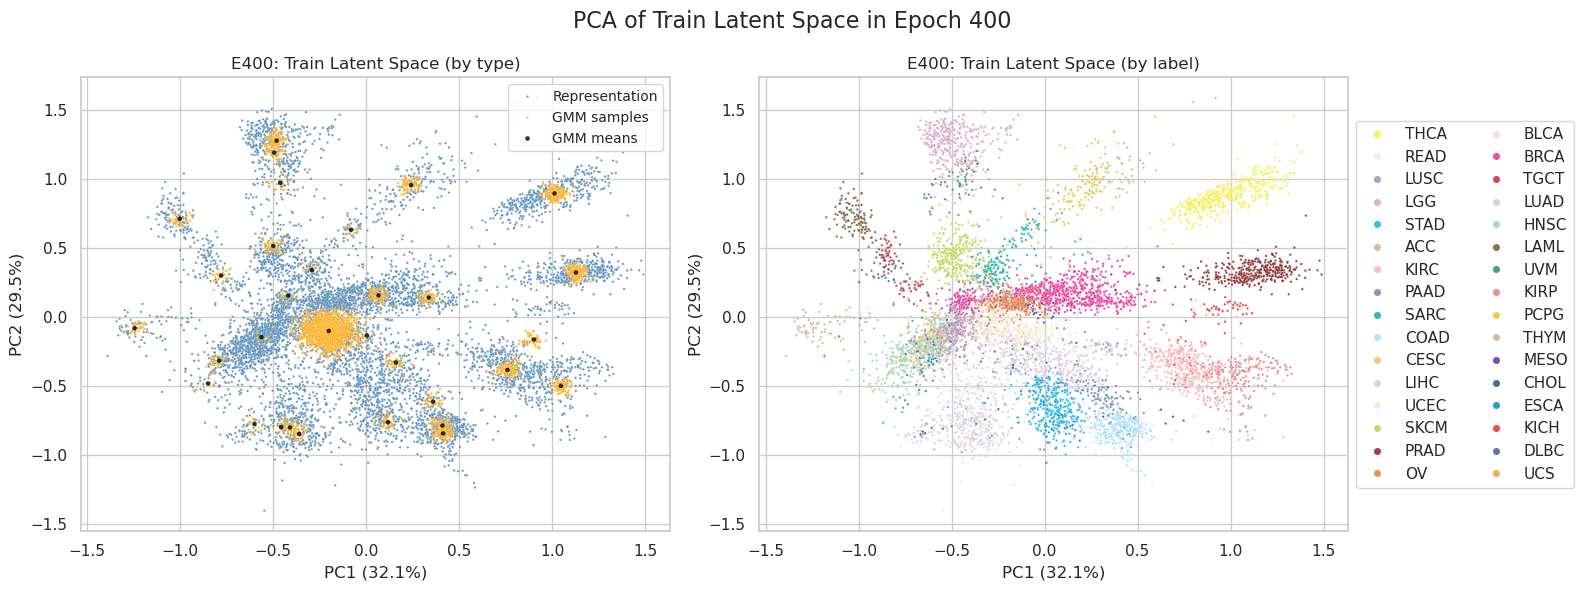

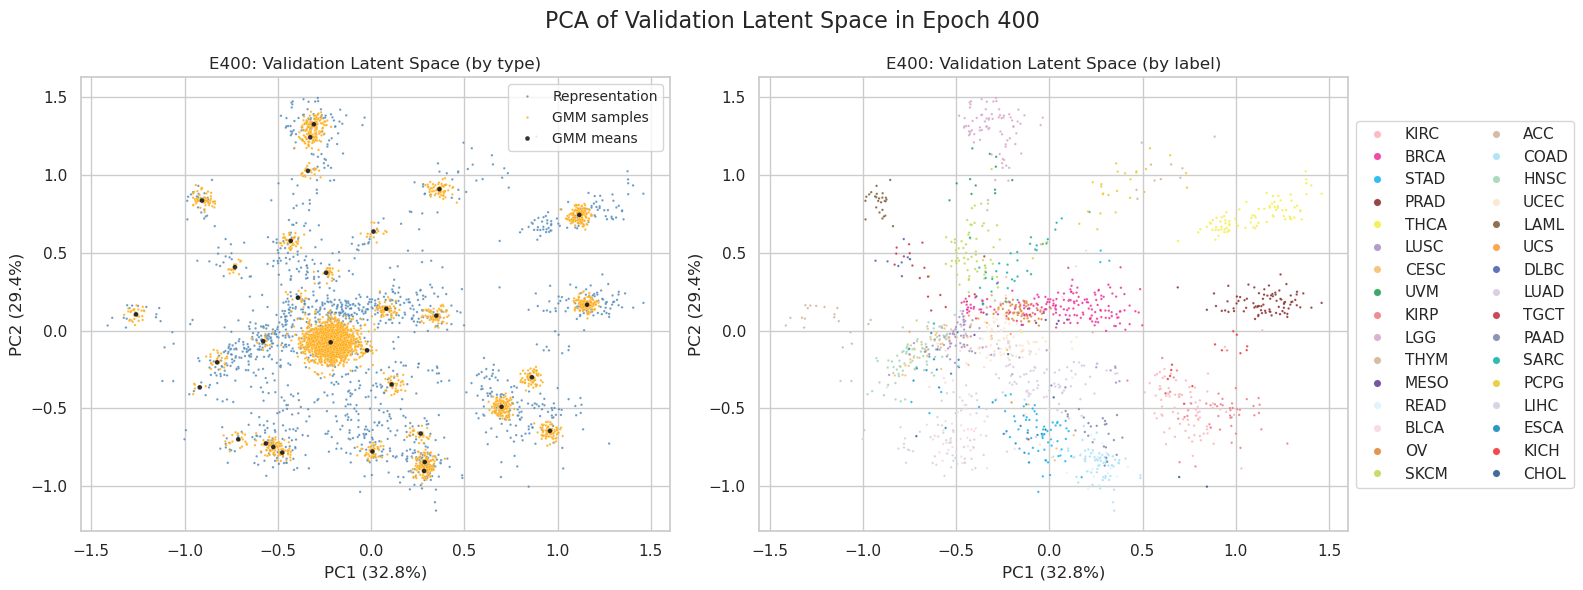

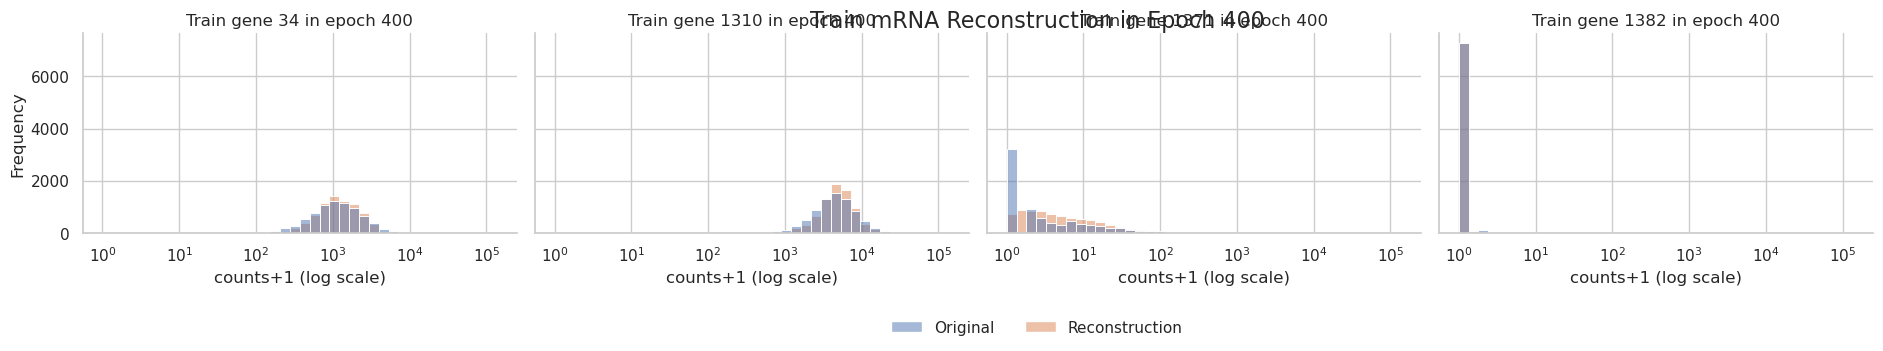

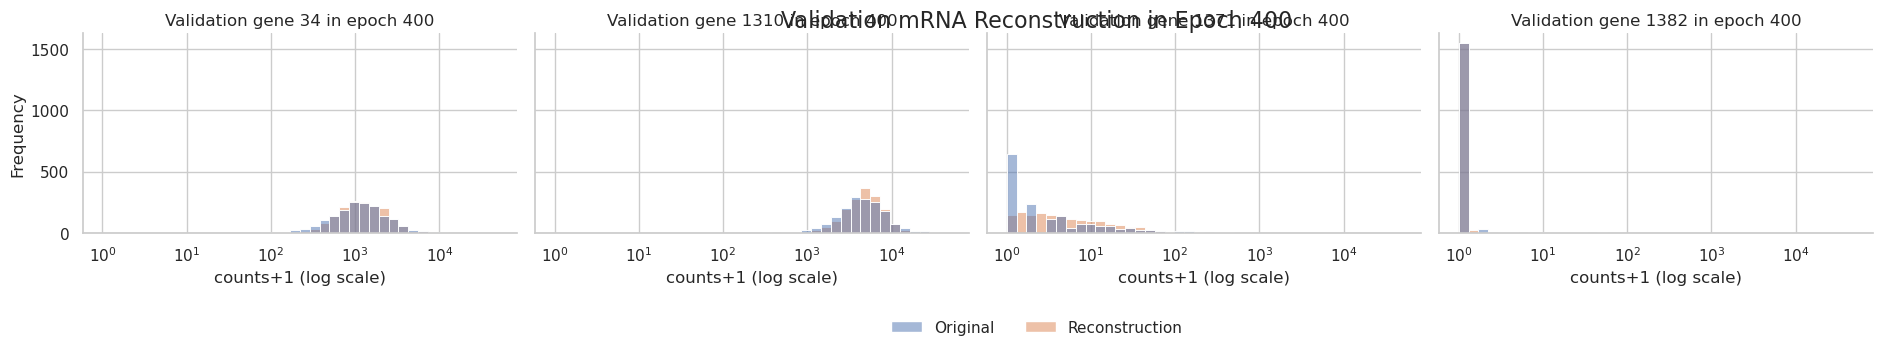

 51%|██████████████████████████████████████████████████████████████▎                                                            | 406/801 [19:34<21:54,  3.33s/it]

405 train_recon: 6.390002696026889 train_gmm: 2.316954989786147 train_mse: 11254569.0 train_mae: 1574.814208984375 train_r2: 0.4732460379600525 train_spearman: 0.8113330602645874 train_pearson: 0.6960856318473816 train_msle: 0.1297290176153183
405 test_recon: 6.3987571436106325 test_gmm: 2.3155347091417475 test_mse: 6111632.0 test_mae: 1449.3070068359375 test_r2: 0.5516068339347839 test_spearman: 0.8159248232841492 test_pearson: 0.7432085275650024 test_msle: 0.12334796041250229


 51%|███████████████████████████████████████████████████████████████                                                            | 411/801 [19:49<19:01,  2.93s/it]

410 train_recon: 6.387251464744908 train_gmm: 2.3181128184511115 train_mse: 11309897.0 train_mae: 1569.142822265625 train_r2: 0.47065645456314087 train_spearman: 0.8122898936271667 train_pearson: 0.6951310038566589 train_msle: 0.12906323373317719
410 test_recon: 6.396436602281874 test_gmm: 2.316174537520495 test_mse: 6097484.5 test_mae: 1451.5091552734375 test_r2: 0.5526447892189026 test_spearman: 0.815559983253479 test_pearson: 0.7438300848007202 test_msle: 0.12345243245363235


 52%|███████████████████████████████████████████████████████████████▉                                                           | 416/801 [20:03<18:26,  2.87s/it]

415 train_recon: 6.384500813027705 train_gmm: 2.319422100551569 train_mse: 11250109.0 train_mae: 1568.54638671875 train_r2: 0.4734547734260559 train_spearman: 0.81255042552948 train_pearson: 0.6974331140518188 train_msle: 0.12886883318424225
415 test_recon: 6.394139727839038 test_gmm: 2.3176782821283575 test_mse: 6081086.5 test_mae: 1445.3260498046875 test_r2: 0.5538478493690491 test_spearman: 0.8164638876914978 test_pearson: 0.7449867725372314 test_msle: 0.12238068133592606


 53%|████████████████████████████████████████████████████████████████▋                                                          | 421/801 [20:17<18:05,  2.86s/it]

420 train_recon: 6.381992836267535 train_gmm: 2.3207120830301586 train_mse: 11276315.0 train_mae: 1562.3433837890625 train_r2: 0.4722282290458679 train_spearman: 0.8132700324058533 train_pearson: 0.6968488693237305 train_msle: 0.1279984563589096
420 test_recon: 6.393172059114945 test_gmm: 2.318553040580106 test_mse: 6081024.0 test_mae: 1448.4796142578125 test_r2: 0.5538524389266968 test_spearman: 0.8169991374015808 test_pearson: 0.7445278763771057 test_msle: 0.12222664803266525


 53%|█████████████████████████████████████████████████████████████████▍                                                         | 426/801 [20:31<17:44,  2.84s/it]

425 train_recon: 6.379426865747642 train_gmm: 2.3217292768288758 train_mse: 11207609.0 train_mae: 1565.8680419921875 train_r2: 0.47544389963150024 train_spearman: 0.8149479031562805 train_pearson: 0.6978115439414978 train_msle: 0.1281467080116272
425 test_recon: 6.389148071523734 test_gmm: 2.3201775974366607 test_mse: 6072910.0 test_mae: 1445.622802734375 test_r2: 0.5544477701187134 test_spearman: 0.8173744082450867 test_pearson: 0.7450442910194397 test_msle: 0.12207287549972534


 54%|██████████████████████████████████████████████████████████████████▏                                                        | 431/801 [20:45<17:33,  2.85s/it]

430 train_recon: 6.37695268337577 train_gmm: 2.3228518254910386 train_mse: 11216139.0 train_mae: 1567.3734130859375 train_r2: 0.4750446677207947 train_spearman: 0.8148540258407593 train_pearson: 0.6969640254974365 train_msle: 0.1282649040222168
430 test_recon: 6.386361975971087 test_gmm: 2.321108236795362 test_mse: 6034367.5 test_mae: 1439.5784912109375 test_r2: 0.5572755336761475 test_spearman: 0.8183719515800476 test_pearson: 0.747239887714386 test_msle: 0.12112873047590256


 54%|██████████████████████████████████████████████████████████████████▉                                                        | 436/801 [21:00<17:24,  2.86s/it]

435 train_recon: 6.374791472762425 train_gmm: 2.3239185628810595 train_mse: 11264020.0 train_mae: 1563.141357421875 train_r2: 0.47280365228652954 train_spearman: 0.8147803544998169 train_pearson: 0.6960281133651733 train_msle: 0.12765735387802124
435 test_recon: 6.383722865068914 test_gmm: 2.3216843004006287 test_mse: 6000064.0 test_mae: 1438.9930419921875 test_r2: 0.5597922801971436 test_spearman: 0.8196893930435181 test_pearson: 0.748674213886261 test_msle: 0.12066777795553207


 55%|███████████████████████████████████████████████████████████████████▋                                                       | 441/801 [21:14<17:05,  2.85s/it]

440 train_recon: 6.372330776286756 train_gmm: 2.324809806841086 train_mse: 11152189.0 train_mae: 1565.5233154296875 train_r2: 0.4780377745628357 train_spearman: 0.8153926134109497 train_pearson: 0.6992946863174438 train_msle: 0.12799280881881714
440 test_recon: 6.381918154276519 test_gmm: 2.323105683764542 test_mse: 6034686.0 test_mae: 1435.42041015625 test_r2: 0.5572521686553955 test_spearman: 0.8195322155952454 test_pearson: 0.7473623156547546 test_msle: 0.12020999193191528


 56%|████████████████████████████████████████████████████████████████████▍                                                      | 446/801 [21:28<16:58,  2.87s/it]

445 train_recon: 6.370276639418784 train_gmm: 2.325866998146452 train_mse: 11176578.0 train_mae: 1557.698486328125 train_r2: 0.4768962860107422 train_spearman: 0.816341757774353 train_pearson: 0.6987941265106201 train_msle: 0.12674519419670105
445 test_recon: 6.381161367630869 test_gmm: 2.3238173895221736 test_mse: 6028060.5 test_mae: 1436.84326171875 test_r2: 0.5577382445335388 test_spearman: 0.8209612965583801 test_pearson: 0.7474571466445923 test_msle: 0.11994144320487976


 56%|█████████████████████████████████████████████████████████████████████▎                                                     | 451/801 [21:43<16:38,  2.85s/it]

450 train_recon: 6.368037516319409 train_gmm: 2.3268088147931514 train_mse: 11158657.0 train_mae: 1565.966796875 train_r2: 0.4777350425720215 train_spearman: 0.8165953755378723 train_pearson: 0.6988393664360046 train_msle: 0.1274477243423462
450 test_recon: 6.378527603926185 test_gmm: 2.3250929899769677 test_mse: 6005799.5 test_mae: 1432.52197265625 test_r2: 0.5593714714050293 test_spearman: 0.8208081126213074 test_pearson: 0.7485558390617371 test_msle: 0.11969032883644104


 57%|██████████████████████████████████████████████████████████████████████                                                     | 456/801 [21:57<16:23,  2.85s/it]

455 train_recon: 6.36630978965642 train_gmm: 2.3276758390753587 train_mse: 11137835.0 train_mae: 1552.4521484375 train_r2: 0.4787095785140991 train_spearman: 0.8177497982978821 train_pearson: 0.7009965181350708 train_msle: 0.12547896802425385
455 test_recon: 6.3766757017429425 test_gmm: 2.326313982837875 test_mse: 5992036.5 test_mae: 1434.1580810546875 test_r2: 0.5603812336921692 test_spearman: 0.8212333917617798 test_pearson: 0.749123752117157 test_msle: 0.11929041892290115


 58%|██████████████████████████████████████████████████████████████████████▊                                                    | 461/801 [22:11<16:09,  2.85s/it]

460 train_recon: 6.36415176156545 train_gmm: 2.328588827983867 train_mse: 11136000.0 train_mae: 1550.2325439453125 train_r2: 0.47879546880722046 train_spearman: 0.8182306289672852 train_pearson: 0.7011745572090149 train_msle: 0.1251840740442276
460 test_recon: 6.374096106098016 test_gmm: 2.3266124565701123 test_mse: 5973276.0 test_mae: 1431.2152099609375 test_r2: 0.5617575645446777 test_spearman: 0.8222730159759521 test_pearson: 0.7503787279129028 test_msle: 0.11857890337705612


 58%|███████████████████████████████████████████████████████████████████████▌                                                   | 466/801 [22:25<15:54,  2.85s/it]

465 train_recon: 6.362405353258866 train_gmm: 2.3294513667170564 train_mse: 11133151.0 train_mae: 1544.698974609375 train_r2: 0.478928804397583 train_spearman: 0.8181454539299011 train_pearson: 0.7015860676765442 train_msle: 0.12442940473556519
465 test_recon: 6.374276312981404 test_gmm: 2.3275478765712836 test_mse: 5982197.5 test_mae: 1431.9237060546875 test_r2: 0.561103105545044 test_spearman: 0.8211482763290405 test_pearson: 0.7496864199638367 test_msle: 0.11880205571651459


 59%|████████████████████████████████████████████████████████████████████████▎                                                  | 471/801 [22:40<15:35,  2.83s/it]

470 train_recon: 6.360508671600722 train_gmm: 2.330150279286682 train_mse: 11095583.0 train_mae: 1558.73291015625 train_r2: 0.48068714141845703 train_spearman: 0.8192697763442993 train_pearson: 0.7002354860305786 train_msle: 0.1261947602033615
470 test_recon: 6.371329390181235 test_gmm: 2.328341966446752 test_mse: 5928659.0 test_mae: 1425.358642578125 test_r2: 0.5650310516357422 test_spearman: 0.8235443830490112 test_pearson: 0.752450168132782 test_msle: 0.11793632060289383


 59%|█████████████████████████████████████████████████████████████████████████                                                  | 476/801 [22:54<15:22,  2.84s/it]

475 train_recon: 6.3587994028896615 train_gmm: 2.3309004898101917 train_mse: 11109501.0 train_mae: 1542.1636962890625 train_r2: 0.4800357222557068 train_spearman: 0.8199148178100586 train_pearson: 0.7019695043563843 train_msle: 0.12377853691577911
475 test_recon: 6.376332610997616 test_gmm: 2.3289747191696595 test_mse: 5984048.5 test_mae: 1427.264892578125 test_r2: 0.5609672665596008 test_spearman: 0.8227329850196838 test_pearson: 0.7498724460601807 test_msle: 0.11760129034519196


 60%|█████████████████████████████████████████████████████████████████████████▊                                                 | 481/801 [23:08<15:07,  2.84s/it]

480 train_recon: 6.357191974894636 train_gmm: 2.331463875420263 train_mse: 11075460.0 train_mae: 1545.3343505859375 train_r2: 0.481628954410553 train_spearman: 0.8202205300331116 train_pearson: 0.7017598748207092 train_msle: 0.1244380995631218
480 test_recon: 6.369318749005113 test_gmm: 2.330068502718028 test_mse: 5961201.0 test_mae: 1429.2845458984375 test_r2: 0.5626435279846191 test_spearman: 0.8231947422027588 test_pearson: 0.7508972883224487 test_msle: 0.11791403591632843


 61%|██████████████████████████████████████████████████████████████████████████▋                                                | 486/801 [23:22<14:50,  2.83s/it]

485 train_recon: 6.355527912236242 train_gmm: 2.3323193656669217 train_mse: 11084466.0 train_mae: 1543.6971435546875 train_r2: 0.4812074303627014 train_spearman: 0.8214346766471863 train_pearson: 0.7025858759880066 train_msle: 0.1238260269165039
485 test_recon: 6.3669753950764205 test_gmm: 2.3296098965246332 test_mse: 5924751.5 test_mae: 1424.0540771484375 test_r2: 0.5653177499771118 test_spearman: 0.8255398273468018 test_pearson: 0.7524916529655457 test_msle: 0.11656040698289871


 61%|███████████████████████████████████████████████████████████████████████████▍                                               | 491/801 [23:36<14:45,  2.86s/it]

490 train_recon: 6.3538627277302355 train_gmm: 2.3329678656313773 train_mse: 11065963.0 train_mae: 1546.0294189453125 train_r2: 0.48207342624664307 train_spearman: 0.8211891055107117 train_pearson: 0.7026602029800415 train_msle: 0.1241147518157959
490 test_recon: 6.364628655643994 test_gmm: 2.330680798560958 test_mse: 5884948.0 test_mae: 1417.468017578125 test_r2: 0.5682380199432373 test_spearman: 0.8259642124176025 test_pearson: 0.754600465297699 test_msle: 0.11599119752645493


 62%|████████████████████████████████████████████████████████████████████████████▏                                              | 496/801 [23:51<14:26,  2.84s/it]

495 train_recon: 6.35237859112656 train_gmm: 2.333604302311237 train_mse: 11090415.0 train_mae: 1532.9246826171875 train_r2: 0.48092901706695557 train_spearman: 0.8217212557792664 train_pearson: 0.7041362524032593 train_msle: 0.12233281880617142
495 test_recon: 6.365099240663152 test_gmm: 2.3318488231232433 test_mse: 5934552.5 test_mae: 1426.3111572265625 test_r2: 0.5645986795425415 test_spearman: 0.8240598440170288 test_pearson: 0.7520401477813721 test_msle: 0.116645447909832


 63%|████████████████████████████████████████████████████████████████████████████▉                                              | 501/801 [24:05<14:15,  2.85s/it]

500 train_recon: 6.350909011427682 train_gmm: 2.3341353318561406 train_mse: 10942171.0 train_mae: 1539.14453125 train_r2: 0.4878673553466797 train_spearman: 0.8230012655258179 train_pearson: 0.706636369228363 train_msle: 0.12290039658546448
500 test_recon: 6.361630712986138 test_gmm: 2.3320943971785213 test_mse: 5871757.0 test_mae: 1417.0133056640625 test_r2: 0.5692057609558105 test_spearman: 0.8266859650611877 test_pearson: 0.7555073499679565 test_msle: 0.11515683680772781


 63%|█████████████████████████████████████████████████████████████████████████████▋                                             | 506/801 [24:19<13:59,  2.85s/it]

505 train_recon: 6.349492460211336 train_gmm: 2.334944236752308 train_mse: 10991082.0 train_mae: 1542.2882080078125 train_r2: 0.48557817935943604 train_spearman: 0.8229139447212219 train_pearson: 0.7043851017951965 train_msle: 0.12333758920431137
505 test_recon: 6.365321608142118 test_gmm: 2.332802999712094 test_mse: 5883882.5 test_mae: 1419.830810546875 test_r2: 0.5683161616325378 test_spearman: 0.8261055946350098 test_pearson: 0.7546212077140808 test_msle: 0.11595284193754196


 64%|██████████████████████████████████████████████████████████████████████████████▍                                            | 511/801 [24:33<13:44,  2.84s/it]

510 train_recon: 6.348163772371006 train_gmm: 2.335455037222543 train_mse: 11025875.0 train_mae: 1530.584716796875 train_r2: 0.4839497208595276 train_spearman: 0.8236117362976074 train_pearson: 0.7048686146736145 train_msle: 0.1216166540980339
510 test_recon: 6.362107151446333 test_gmm: 2.3328569363386165 test_mse: 5877241.0 test_mae: 1413.8984375 test_r2: 0.5688034296035767 test_spearman: 0.8275614380836487 test_pearson: 0.7552497982978821 test_msle: 0.11470866203308105


 64%|███████████████████████████████████████████████████████████████████████████████▏                                           | 516/801 [24:47<13:28,  2.84s/it]

515 train_recon: 6.346688078433186 train_gmm: 2.3357834623916935 train_mse: 11018172.0 train_mae: 1538.021240234375 train_r2: 0.4843102693557739 train_spearman: 0.8247050046920776 train_pearson: 0.7034914493560791 train_msle: 0.12226302176713943
515 test_recon: 6.360276179269826 test_gmm: 2.3341430892801376 test_mse: 5844991.0 test_mae: 1416.1328125 test_r2: 0.5711694955825806 test_spearman: 0.8273840546607971 test_pearson: 0.7564696073532104 test_msle: 0.11507014185190201


 65%|████████████████████████████████████████████████████████████████████████████████                                           | 521/801 [25:02<13:10,  2.82s/it]

520 train_recon: 6.345325345398747 train_gmm: 2.336384989869781 train_mse: 10961664.0 train_mae: 1524.414794921875 train_r2: 0.48695504665374756 train_spearman: 0.825788676738739 train_pearson: 0.7073092460632324 train_msle: 0.12074199318885803
520 test_recon: 6.358069131416744 test_gmm: 2.3339797620993714 test_mse: 5858687.5 test_mae: 1414.9190673828125 test_r2: 0.570164680480957 test_spearman: 0.826980710029602 test_pearson: 0.7558046579360962 test_msle: 0.11483428627252579


 66%|████████████████████████████████████████████████████████████████████████████████▊                                          | 526/801 [25:16<13:06,  2.86s/it]

525 train_recon: 6.344103114457068 train_gmm: 2.336784259270875 train_mse: 10919814.0 train_mae: 1527.6490478515625 train_r2: 0.48891377449035645 train_spearman: 0.8256797790527344 train_pearson: 0.7078424692153931 train_msle: 0.12103839963674545
525 test_recon: 6.357068161359183 test_gmm: 2.334904210259213 test_mse: 5847619.5 test_mae: 1415.992919921875 test_r2: 0.5709766745567322 test_spearman: 0.8282924294471741 test_pearson: 0.756113588809967 test_msle: 0.11463098227977753


 66%|█████████████████████████████████████████████████████████████████████████████████▌                                         | 531/801 [25:30<12:54,  2.87s/it]

530 train_recon: 6.342908092556535 train_gmm: 2.337182774002032 train_mse: 10946440.0 train_mae: 1517.5745849609375 train_r2: 0.4876675605773926 train_spearman: 0.8268167972564697 train_pearson: 0.7087075710296631 train_msle: 0.11963136494159698
530 test_recon: 6.356133287725008 test_gmm: 2.335340735526624 test_mse: 5857687.0 test_mae: 1415.53076171875 test_r2: 0.5702380537986755 test_spearman: 0.8276229500770569 test_pearson: 0.7557299733161926 test_msle: 0.1146635040640831


 67%|██████████████████████████████████████████████████████████████████████████████████▎                                        | 536/801 [25:45<12:45,  2.89s/it]

535 train_recon: 6.341737510665433 train_gmm: 2.337639806689499 train_mse: 10903287.0 train_mae: 1525.6439208984375 train_r2: 0.4896872639656067 train_spearman: 0.8266957998275757 train_pearson: 0.7080123424530029 train_msle: 0.12094003707170486
535 test_recon: 6.3537864533719155 test_gmm: 2.335333484504314 test_mse: 5842771.5 test_mae: 1409.64892578125 test_r2: 0.5713323354721069 test_spearman: 0.8295881748199463 test_pearson: 0.756706953048706 test_msle: 0.11375489830970764


 68%|███████████████████████████████████████████████████████████████████████████████████                                        | 541/801 [25:59<12:18,  2.84s/it]

540 train_recon: 6.3404457760109025 train_gmm: 2.338178882780092 train_mse: 10903852.0 train_mae: 1515.47509765625 train_r2: 0.4896608591079712 train_spearman: 0.8273428082466125 train_pearson: 0.70908522605896 train_msle: 0.11938241124153137
540 test_recon: 6.353882718746809 test_gmm: 2.3356500209829796 test_mse: 5823905.5 test_mae: 1408.8902587890625 test_r2: 0.5727165341377258 test_spearman: 0.829831600189209 test_pearson: 0.75739985704422 test_msle: 0.113286092877388


 68%|███████████████████████████████████████████████████████████████████████████████████▊                                       | 546/801 [26:13<12:01,  2.83s/it]

545 train_recon: 6.339356095939947 train_gmm: 2.3383864072117957 train_mse: 10832365.0 train_mae: 1522.0924072265625 train_r2: 0.49300670623779297 train_spearman: 0.8277203440666199 train_pearson: 0.709930419921875 train_msle: 0.12017049640417099
545 test_recon: 6.3523302912631125 test_gmm: 2.336480754826085 test_mse: 5814599.5 test_mae: 1402.2191162109375 test_r2: 0.5733992457389832 test_spearman: 0.8315891027450562 test_pearson: 0.7583131194114685 test_msle: 0.11255962401628494


 69%|████████████████████████████████████████████████████████████████████████████████████▌                                      | 551/801 [26:27<11:42,  2.81s/it]

550 train_recon: 6.338179162561162 train_gmm: 2.3386809343062107 train_mse: 10831707.0 train_mae: 1513.33251953125 train_r2: 0.49303746223449707 train_spearman: 0.8289015889167786 train_pearson: 0.7115901708602905 train_msle: 0.11890076845884323
550 test_recon: 6.351042344393626 test_gmm: 2.3370723498009056 test_mse: 5807344.0 test_mae: 1401.9638671875 test_r2: 0.5739315748214722 test_spearman: 0.8308258652687073 test_pearson: 0.7585607171058655 test_msle: 0.11249164491891861


 69%|█████████████████████████████████████████████████████████████████████████████████████▍                                     | 556/801 [26:41<11:33,  2.83s/it]

555 train_recon: 6.337210140420547 train_gmm: 2.339118203462151 train_mse: 10866583.0 train_mae: 1522.78466796875 train_r2: 0.4914051294326782 train_spearman: 0.8290693163871765 train_pearson: 0.708824872970581 train_msle: 0.12022411823272705
555 test_recon: 6.3519899848573065 test_gmm: 2.3372407016122736 test_mse: 5816127.0 test_mae: 1401.5594482421875 test_r2: 0.5732871890068054 test_spearman: 0.8312997221946716 test_pearson: 0.7581116557121277 test_msle: 0.11281941831111908


 70%|██████████████████████████████████████████████████████████████████████████████████████▏                                    | 561/801 [26:55<11:21,  2.84s/it]

560 train_recon: 6.336155712123003 train_gmm: 2.339446172889067 train_mse: 10854048.0 train_mae: 1516.4173583984375 train_r2: 0.49199187755584717 train_spearman: 0.8300460577011108 train_pearson: 0.7101500034332275 train_msle: 0.11910988390445709
560 test_recon: 6.3492063097816285 test_gmm: 2.3373827027053404 test_mse: 5805863.0 test_mae: 1400.65185546875 test_r2: 0.5740402936935425 test_spearman: 0.8313431739807129 test_pearson: 0.7585594654083252 test_msle: 0.11238615959882736


 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 566/801 [27:09<11:06,  2.84s/it]

565 train_recon: 6.33515709150751 train_gmm: 2.339883711569985 train_mse: 10791368.0 train_mae: 1508.8116455078125 train_r2: 0.49492543935775757 train_spearman: 0.8304374814033508 train_pearson: 0.712192952632904 train_msle: 0.11805421113967896
565 test_recon: 6.348831499713925 test_gmm: 2.3374498299402715 test_mse: 5793389.5 test_mae: 1399.3919677734375 test_r2: 0.574955403804779 test_spearman: 0.8315614461898804 test_pearson: 0.7590810656547546 test_msle: 0.11230248957872391


 71%|███████████████████████████████████████████████████████████████████████████████████████▋                                   | 571/801 [27:24<10:53,  2.84s/it]

570 train_recon: 6.334074034065652 train_gmm: 2.340176160871847 train_mse: 10804327.0 train_mae: 1506.6728515625 train_r2: 0.49431896209716797 train_spearman: 0.8307250142097473 train_pearson: 0.7125180959701538 train_msle: 0.11776989698410034
570 test_recon: 6.346899421208586 test_gmm: 2.3379095493295208 test_mse: 5768023.0 test_mae: 1397.3526611328125 test_r2: 0.5768164396286011 test_spearman: 0.8322756290435791 test_pearson: 0.7603247761726379 test_msle: 0.11177276819944382


 72%|████████████████████████████████████████████████████████████████████████████████████████▍                                  | 576/801 [27:38<10:37,  2.83s/it]

575 train_recon: 6.333062652857245 train_gmm: 2.340512461070792 train_mse: 10829661.0 train_mae: 1502.330810546875 train_r2: 0.49313318729400635 train_spearman: 0.8310774564743042 train_pearson: 0.711896538734436 train_msle: 0.11707601696252823
575 test_recon: 6.346837311453149 test_gmm: 2.338429160180649 test_mse: 5773699.0 test_mae: 1397.7005615234375 test_r2: 0.5764000415802002 test_spearman: 0.8324490189552307 test_pearson: 0.7600634694099426 test_msle: 0.11155326664447784


 73%|█████████████████████████████████████████████████████████████████████████████████████████▏                                 | 581/801 [27:52<10:30,  2.86s/it]

580 train_recon: 6.332117494550549 train_gmm: 2.340897027475997 train_mse: 10831301.0 train_mae: 1502.3604736328125 train_r2: 0.4930564761161804 train_spearman: 0.8316638469696045 train_pearson: 0.7125290036201477 train_msle: 0.11689431220293045
580 test_recon: 6.346244705918535 test_gmm: 2.3387146949172393 test_mse: 5748897.5 test_mae: 1390.21240234375 test_r2: 0.5782196521759033 test_spearman: 0.8336293697357178 test_pearson: 0.7616480588912964 test_msle: 0.11068116873502731


 73%|█████████████████████████████████████████████████████████████████████████████████████████▉                                 | 586/801 [28:06<10:08,  2.83s/it]

585 train_recon: 6.331248045705875 train_gmm: 2.3411314733692334 train_mse: 10771137.0 train_mae: 1502.5596923828125 train_r2: 0.4958723783493042 train_spearman: 0.8320862650871277 train_pearson: 0.7128738164901733 train_msle: 0.11707625538110733
585 test_recon: 6.3451345454554655 test_gmm: 2.339507320863913 test_mse: 5703068.0 test_mae: 1385.9241943359375 test_r2: 0.5815820097923279 test_spearman: 0.8338595628738403 test_pearson: 0.7639157772064209 test_msle: 0.11045651137828827


 74%|██████████████████████████████████████████████████████████████████████████████████████████▊                                | 591/801 [28:21<09:59,  2.86s/it]

590 train_recon: 6.3302696183473754 train_gmm: 2.3413587842012493 train_mse: 10736356.0 train_mae: 1498.6959228515625 train_r2: 0.4975002408027649 train_spearman: 0.8329460620880127 train_pearson: 0.714651346206665 train_msle: 0.11631699651479721
590 test_recon: 6.343022465728182 test_gmm: 2.339873455555122 test_mse: 5748728.5 test_mae: 1389.629638671875 test_r2: 0.5782320499420166 test_spearman: 0.8333106637001038 test_pearson: 0.7613698840141296 test_msle: 0.11085538566112518


 74%|███████████████████████████████████████████████████████████████████████████████████████████▌                               | 596/801 [28:35<09:40,  2.83s/it]

595 train_recon: 6.329494397923469 train_gmm: 2.341694925952178 train_mse: 10773692.0 train_mae: 1499.6434326171875 train_r2: 0.49575281143188477 train_spearman: 0.8328867554664612 train_pearson: 0.713263213634491 train_msle: 0.11638876795768738
595 test_recon: 6.346575994861122 test_gmm: 2.340372960259213 test_mse: 5707447.5 test_mae: 1391.4403076171875 test_r2: 0.5812606811523438 test_spearman: 0.8339881896972656 test_pearson: 0.763197124004364 test_msle: 0.11046189814805984


 75%|████████████████████████████████████████████████████████████████████████████████████████████▎                              | 601/801 [28:49<09:29,  2.85s/it]

600 train_recon: 6.3285696091156876 train_gmm: 2.341968487270319 train_mse: 10739383.0 train_mae: 1495.0830078125 train_r2: 0.4973585605621338 train_spearman: 0.8343535661697388 train_pearson: 0.7145968675613403 train_msle: 0.11570021510124207
600 test_recon: 6.342955024595368 test_gmm: 2.3394312423143737 test_mse: 5702992.0 test_mae: 1382.375732421875 test_r2: 0.581587553024292 test_spearman: 0.8346690535545349 test_pearson: 0.7639424800872803 test_msle: 0.10960220545530319


 76%|█████████████████████████████████████████████████████████████████████████████████████████████                              | 606/801 [29:03<09:09,  2.82s/it]

605 train_recon: 6.3275273516784765 train_gmm: 2.3421778003677822 train_mse: 10668999.0 train_mae: 1499.0504150390625 train_r2: 0.5006527900695801 train_spearman: 0.8346819281578064 train_pearson: 0.7156575322151184 train_msle: 0.11608035862445831
605 test_recon: 6.343044930285675 test_gmm: 2.339816301335103 test_mse: 5686214.0 test_mae: 1384.6456298828125 test_r2: 0.5828185081481934 test_spearman: 0.834956169128418 test_pearson: 0.7643308639526367 test_msle: 0.10968989878892899


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▊                             | 611/801 [29:17<08:58,  2.83s/it]

610 train_recon: 6.326919066246172 train_gmm: 2.34232565686994 train_mse: 10677917.0 train_mae: 1496.9537353515625 train_r2: 0.5002354383468628 train_spearman: 0.8348564505577087 train_pearson: 0.7156662940979004 train_msle: 0.11590507626533508
610 test_recon: 6.341332529840447 test_gmm: 2.3400359973990863 test_mse: 5678141.0 test_mae: 1378.525390625 test_r2: 0.5834108591079712 test_spearman: 0.8345091342926025 test_pearson: 0.7653711438179016 test_msle: 0.10945260524749756


 77%|██████████████████████████████████████████████████████████████████████████████████████████████▌                            | 616/801 [29:31<08:40,  2.82s/it]

615 train_recon: 6.326054887712782 train_gmm: 2.3425035270201895 train_mse: 10677112.0 train_mae: 1493.3363037109375 train_r2: 0.5002730488777161 train_spearman: 0.8350741267204285 train_pearson: 0.7165514230728149 train_msle: 0.11512670665979385
615 test_recon: 6.341144808404377 test_gmm: 2.340991721787652 test_mse: 5650272.5 test_mae: 1382.1514892578125 test_r2: 0.5854554772377014 test_spearman: 0.8351694345474243 test_pearson: 0.7661165595054626 test_msle: 0.109221912920475


 78%|███████████████████████████████████████████████████████████████████████████████████████████████▎                           | 621/801 [29:45<08:29,  2.83s/it]

620 train_recon: 6.3253043987753275 train_gmm: 2.3427963291547487 train_mse: 10637493.0 train_mae: 1495.9097900390625 train_r2: 0.5021274089813232 train_spearman: 0.8359726667404175 train_pearson: 0.7168459892272949 train_msle: 0.11537617444992065
620 test_recon: 6.341678041062743 test_gmm: 2.3407238609414036 test_mse: 5667998.0 test_mae: 1382.125732421875 test_r2: 0.5841549634933472 test_spearman: 0.8347240090370178 test_pearson: 0.7654286623001099 test_msle: 0.10928583145141602


 78%|████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 626/801 [29:59<08:09,  2.80s/it]

625 train_recon: 6.3245653011666345 train_gmm: 2.3429031443535266 train_mse: 10706752.0 train_mae: 1486.8074951171875 train_r2: 0.4988858103752136 train_spearman: 0.8360002040863037 train_pearson: 0.7158336639404297 train_msle: 0.11430253833532333
625 test_recon: 6.3389109454633 test_gmm: 2.340516028800359 test_mse: 5687019.5 test_mae: 1382.944580078125 test_r2: 0.5827594995498657 test_spearman: 0.8349841237068176 test_pearson: 0.7643589377403259 test_msle: 0.10911234468221664


 79%|████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 631/801 [30:13<07:59,  2.82s/it]

630 train_recon: 6.323554584254698 train_gmm: 2.3432197806635138 train_mse: 10655857.0 train_mae: 1488.4525146484375 train_r2: 0.5012679100036621 train_spearman: 0.8370510339736938 train_pearson: 0.7167627215385437 train_msle: 0.11426788568496704
630 test_recon: 6.342175108947567 test_gmm: 2.341443366694644 test_mse: 5634382.0 test_mae: 1376.140625 test_r2: 0.5866212844848633 test_spearman: 0.8365993499755859 test_pearson: 0.7671235203742981 test_msle: 0.10819648206233978


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 636/801 [30:28<07:44,  2.82s/it]

635 train_recon: 6.322898727060869 train_gmm: 2.3434046617301454 train_mse: 10613930.0 train_mae: 1485.46630859375 train_r2: 0.5032302141189575 train_spearman: 0.8369453549385071 train_pearson: 0.7190317511558533 train_msle: 0.11381667107343674
635 test_recon: 6.337418840062507 test_gmm: 2.341646303823782 test_mse: 5695708.5 test_mae: 1381.82568359375 test_r2: 0.5821219682693481 test_spearman: 0.8359555006027222 test_pearson: 0.764018714427948 test_msle: 0.1089140921831131


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 641/801 [30:42<07:30,  2.82s/it]

640 train_recon: 6.322171125848235 train_gmm: 2.3435081952581376 train_mse: 10632350.0 train_mae: 1489.917724609375 train_r2: 0.5023680925369263 train_spearman: 0.8376034498214722 train_pearson: 0.7166644334793091 train_msle: 0.11410019546747208
640 test_recon: 6.337250007838865 test_gmm: 2.3417131108242897 test_mse: 5670403.0 test_mae: 1373.3134765625 test_r2: 0.583978533744812 test_spearman: 0.8373425602912903 test_pearson: 0.7656904458999634 test_msle: 0.10773656517267227


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 646/801 [30:56<07:20,  2.84s/it]

645 train_recon: 6.321624104818987 train_gmm: 2.343727632693844 train_mse: 10604862.0 train_mae: 1484.965576171875 train_r2: 0.5036545991897583 train_spearman: 0.8379297852516174 train_pearson: 0.7187609076499939 train_msle: 0.11380746215581894
645 test_recon: 6.338591743085448 test_gmm: 2.3419733165428833 test_mse: 5633767.5 test_mae: 1378.0411376953125 test_r2: 0.5866664052009583 test_spearman: 0.8368306159973145 test_pearson: 0.7666916847229004 test_msle: 0.10843212157487869


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 651/801 [31:10<07:05,  2.84s/it]

650 train_recon: 6.320755889667758 train_gmm: 2.343913070778762 train_mse: 10614933.0 train_mae: 1479.7718505859375 train_r2: 0.5031832456588745 train_spearman: 0.8382086753845215 train_pearson: 0.7189153432846069 train_msle: 0.11305992305278778
650 test_recon: 6.339299360826387 test_gmm: 2.3418344186738755 test_mse: 5632233.5 test_mae: 1375.2030029296875 test_r2: 0.5867789387702942 test_spearman: 0.8377114534378052 test_pearson: 0.7670167684555054 test_msle: 0.10763160139322281


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 656/801 [31:24<06:51,  2.84s/it]

655 train_recon: 6.320193874518179 train_gmm: 2.3440994693526904 train_mse: 10614619.0 train_mae: 1484.2862548828125 train_r2: 0.5031979084014893 train_spearman: 0.8392589092254639 train_pearson: 0.7172760963439941 train_msle: 0.1133609414100647
655 test_recon: 6.334212768025505 test_gmm: 2.3420023740045286 test_mse: 5601244.5 test_mae: 1372.5203857421875 test_r2: 0.5890525579452515 test_spearman: 0.8372271656990051 test_pearson: 0.768717885017395 test_msle: 0.10769546031951904


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 661/801 [31:38<06:35,  2.82s/it]

660 train_recon: 6.31938590021116 train_gmm: 2.344341184252894 train_mse: 10606341.0 train_mae: 1479.479248046875 train_r2: 0.5035854578018188 train_spearman: 0.8390140533447266 train_pearson: 0.7184072732925415 train_msle: 0.11277687549591064
660 test_recon: 6.336429576887021 test_gmm: 2.3417937184035367 test_mse: 5644284.0 test_mae: 1373.55517578125 test_r2: 0.5858948230743408 test_spearman: 0.8367063403129578 test_pearson: 0.7665302157402039 test_msle: 0.10776271671056747


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 666/801 [31:53<06:22,  2.83s/it]

665 train_recon: 6.318667592370577 train_gmm: 2.344444588735594 train_mse: 10590996.0 train_mae: 1478.8291015625 train_r2: 0.5043035745620728 train_spearman: 0.8394699692726135 train_pearson: 0.719325602054596 train_msle: 0.11262822896242142
665 test_recon: 6.334198545745797 test_gmm: 2.342640265727475 test_mse: 5600542.0 test_mae: 1370.665283203125 test_r2: 0.5891040563583374 test_spearman: 0.8379714488983154 test_pearson: 0.7686810493469238 test_msle: 0.10708881914615631


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████                    | 671/801 [32:07<06:12,  2.87s/it]

670 train_recon: 6.318145699372104 train_gmm: 2.344536705838937 train_mse: 10614137.0 train_mae: 1472.4969482421875 train_r2: 0.5032205581665039 train_spearman: 0.8393492698669434 train_pearson: 0.7203910946846008 train_msle: 0.11189824342727661
670 test_recon: 6.335946035197026 test_gmm: 2.3422692283997306 test_mse: 5608290.5 test_mae: 1367.14501953125 test_r2: 0.5885355472564697 test_spearman: 0.8382413387298584 test_pearson: 0.7683547735214233 test_msle: 0.10695691406726837


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 676/801 [32:21<05:59,  2.88s/it]

675 train_recon: 6.317580162773377 train_gmm: 2.3446972528838192 train_mse: 10645916.0 train_mae: 1472.72021484375 train_r2: 0.5017331838607788 train_spearman: 0.839868426322937 train_pearson: 0.7185951471328735 train_msle: 0.11187245696783066
675 test_recon: 6.33779293822522 test_gmm: 2.342869385833073 test_mse: 5643202.0 test_mae: 1367.6025390625 test_r2: 0.5859742164611816 test_spearman: 0.8381046056747437 test_pearson: 0.7670855522155762 test_msle: 0.10679656267166138


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 681/801 [32:35<05:39,  2.83s/it]

680 train_recon: 6.316808396013264 train_gmm: 2.344881214298558 train_mse: 10594575.0 train_mae: 1472.6876220703125 train_r2: 0.5041360855102539 train_spearman: 0.8409546613693237 train_pearson: 0.71932452917099 train_msle: 0.11199355125427246
680 test_recon: 6.33544458514148 test_gmm: 2.3429197388839005 test_mse: 5600720.5 test_mae: 1370.295166015625 test_r2: 0.5890909433364868 test_spearman: 0.8390226364135742 test_pearson: 0.7689670920372009 test_msle: 0.10665396600961685


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 686/801 [32:50<05:26,  2.84s/it]

685 train_recon: 6.316462748324781 train_gmm: 2.3450098414186904 train_mse: 10582128.0 train_mae: 1473.1119384765625 train_r2: 0.5047186613082886 train_spearman: 0.8407045602798462 train_pearson: 0.7196075916290283 train_msle: 0.11190805584192276
685 test_recon: 6.332038024838903 test_gmm: 2.3430764402619455 test_mse: 5582068.0 test_mae: 1369.604736328125 test_r2: 0.5904594659805298 test_spearman: 0.8383814096450806 test_pearson: 0.7694333791732788 test_msle: 0.10668165981769562


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 691/801 [33:04<05:10,  2.82s/it]

690 train_recon: 6.315604453560129 train_gmm: 2.345187633161674 train_mse: 10554920.0 train_mae: 1469.42236328125 train_r2: 0.5059921145439148 train_spearman: 0.8417727947235107 train_pearson: 0.7208341956138611 train_msle: 0.11125915497541428
690 test_recon: 6.3348244367937685 test_gmm: 2.3430779194399984 test_mse: 5574108.5 test_mae: 1367.2440185546875 test_r2: 0.5910433530807495 test_spearman: 0.8388222455978394 test_pearson: 0.7698286771774292 test_msle: 0.10666848719120026


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 696/801 [33:18<04:58,  2.84s/it]

695 train_recon: 6.314937798159388 train_gmm: 2.345293875007318 train_mse: 10616835.0 train_mae: 1467.53857421875 train_r2: 0.5030942559242249 train_spearman: 0.841923713684082 train_pearson: 0.7189516425132751 train_msle: 0.11104954034090042
695 test_recon: 6.329265582041972 test_gmm: 2.3434582206921455 test_mse: 5586215.0 test_mae: 1368.5740966796875 test_r2: 0.5901551842689514 test_spearman: 0.8388282060623169 test_pearson: 0.7693877220153809 test_msle: 0.10652107000350952


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 701/801 [33:32<04:42,  2.83s/it]

700 train_recon: 6.314550553988347 train_gmm: 2.3453948308964354 train_mse: 10487129.0 train_mae: 1467.8179931640625 train_r2: 0.5091649293899536 train_spearman: 0.8422674536705017 train_pearson: 0.7223312258720398 train_msle: 0.11108482629060745
700 test_recon: 6.331726115532182 test_gmm: 2.343638688039214 test_mse: 5541836.5 test_mae: 1364.596923828125 test_r2: 0.5934110879898071 test_spearman: 0.8401305079460144 test_pearson: 0.7716283798217773 test_msle: 0.10591209679841995


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 706/801 [33:46<04:29,  2.83s/it]

705 train_recon: 6.314012968680394 train_gmm: 2.345593438135099 train_mse: 10523022.0 train_mae: 1472.2353515625 train_r2: 0.507485032081604 train_spearman: 0.8424752354621887 train_pearson: 0.7206172943115234 train_msle: 0.11156236380338669
705 test_recon: 6.328606721882862 test_gmm: 2.3439909077822456 test_mse: 5591641.5 test_mae: 1367.373291015625 test_r2: 0.5897570848464966 test_spearman: 0.8393158912658691 test_pearson: 0.7691489458084106 test_msle: 0.10635875165462494


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 711/801 [34:01<04:16,  2.85s/it]

710 train_recon: 6.31332149367224 train_gmm: 2.3456518531818715 train_mse: 10576731.0 train_mae: 1463.1795654296875 train_r2: 0.5049712657928467 train_spearman: 0.8424202799797058 train_pearson: 0.7204152345657349 train_msle: 0.11061806231737137
710 test_recon: 6.329025970642114 test_gmm: 2.3441117276555667 test_mse: 5563959.5 test_mae: 1360.6923828125 test_r2: 0.5917879939079285 test_spearman: 0.839625895023346 test_pearson: 0.7705700397491455 test_msle: 0.10555590689182281


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 716/801 [34:15<03:59,  2.82s/it]

715 train_recon: 6.312764226886718 train_gmm: 2.345775075101093 train_mse: 10537871.0 train_mae: 1465.0416259765625 train_r2: 0.506790041923523 train_spearman: 0.8431341648101807 train_pearson: 0.7208958268165588 train_msle: 0.11051741987466812
715 test_recon: 6.328875331546019 test_gmm: 2.3433839796782285 test_mse: 5519812.0 test_mae: 1361.7037353515625 test_r2: 0.595026969909668 test_spearman: 0.8398744463920593 test_pearson: 0.7724762558937073 test_msle: 0.10581176728010178


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 721/801 [34:29<03:46,  2.83s/it]

720 train_recon: 6.312156341388002 train_gmm: 2.3459080309557114 train_mse: 10550787.0 train_mae: 1465.3204345703125 train_r2: 0.5061855316162109 train_spearman: 0.8435950875282288 train_pearson: 0.7209570407867432 train_msle: 0.11058437079191208
720 test_recon: 6.328643424540175 test_gmm: 2.3437692369393153 test_mse: 5551809.5 test_mae: 1365.1727294921875 test_r2: 0.5926793813705444 test_spearman: 0.8396937847137451 test_pearson: 0.7707821726799011 test_msle: 0.10622009634971619


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 726/801 [34:43<03:34,  2.86s/it]

725 train_recon: 6.311727483788065 train_gmm: 2.3459770130150837 train_mse: 10534359.0 train_mae: 1463.7122802734375 train_r2: 0.5069544315338135 train_spearman: 0.8437613844871521 train_pearson: 0.7212783694267273 train_msle: 0.11040049046278
725 test_recon: 6.327111025316892 test_gmm: 2.3438280609531152 test_mse: 5557213.0 test_mae: 1361.3787841796875 test_r2: 0.5922830104827881 test_spearman: 0.8403353095054626 test_pearson: 0.7706748247146606 test_msle: 0.10584419965744019


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 731/801 [34:57<03:17,  2.83s/it]

730 train_recon: 6.311210894993552 train_gmm: 2.3461034953697895 train_mse: 10436605.0 train_mae: 1467.416748046875 train_r2: 0.5115296244621277 train_spearman: 0.844211757183075 train_pearson: 0.7228113412857056 train_msle: 0.11096224933862686
730 test_recon: 6.328841144286341 test_gmm: 2.3438363641742463 test_mse: 5539147.0 test_mae: 1360.6461181640625 test_r2: 0.5936084389686584 test_spearman: 0.8409544229507446 test_pearson: 0.7717335224151611 test_msle: 0.10541538149118423


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 736/801 [35:11<03:04,  2.84s/it]

735 train_recon: 6.310864464384229 train_gmm: 2.3463278838976565 train_mse: 10532726.0 train_mae: 1462.9659423828125 train_r2: 0.5070308446884155 train_spearman: 0.8439511060714722 train_pearson: 0.7205307483673096 train_msle: 0.11030387878417969
735 test_recon: 6.327612728494213 test_gmm: 2.344280186211743 test_mse: 5535992.5 test_mae: 1363.6500244140625 test_r2: 0.5938398838043213 test_spearman: 0.8402372002601624 test_pearson: 0.7715486884117126 test_msle: 0.1058918908238411


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 741/801 [35:26<02:50,  2.85s/it]

740 train_recon: 6.310003580219049 train_gmm: 2.346403927511437 train_mse: 10459656.0 train_mae: 1462.526611328125 train_r2: 0.5104507207870483 train_spearman: 0.8443535566329956 train_pearson: 0.7228148579597473 train_msle: 0.11024841666221619
740 test_recon: 6.327528723705275 test_gmm: 2.3439727001678636 test_mse: 5578357.0 test_mae: 1359.3934326171875 test_r2: 0.5907317399978638 test_spearman: 0.8407255411148071 test_pearson: 0.7702128887176514 test_msle: 0.10506325960159302


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 746/801 [35:40<02:37,  2.86s/it]

745 train_recon: 6.309610486171947 train_gmm: 2.3465522789594626 train_mse: 10474902.0 train_mae: 1456.1019287109375 train_r2: 0.5097372531890869 train_spearman: 0.844810962677002 train_pearson: 0.7237699627876282 train_msle: 0.10932672768831253
745 test_recon: 6.326935342985225 test_gmm: 2.3447663630641005 test_mse: 5548670.5 test_mae: 1360.7078857421875 test_r2: 0.5929096937179565 test_spearman: 0.8399766087532043 test_pearson: 0.7711472511291504 test_msle: 0.10548894852399826


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 751/801 [35:54<02:20,  2.82s/it]

750 train_recon: 6.309331895145032 train_gmm: 2.346654724586637 train_mse: 10487864.0 train_mae: 1460.07080078125 train_r2: 0.5091305375099182 train_spearman: 0.8449889421463013 train_pearson: 0.721691906452179 train_msle: 0.10966673493385315
750 test_recon: 6.326528702854369 test_gmm: 2.34475760998985 test_mse: 5555458.5 test_mae: 1358.28955078125 test_r2: 0.5924116969108582 test_spearman: 0.8412294983863831 test_pearson: 0.7710217833518982 test_msle: 0.10483407974243164


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 756/801 [36:08<02:08,  2.85s/it]

755 train_recon: 6.308718607153593 train_gmm: 2.3468210803031537 train_mse: 10475226.0 train_mae: 1458.7469482421875 train_r2: 0.5097220540046692 train_spearman: 0.8442517518997192 train_pearson: 0.7237282395362854 train_msle: 0.10965033620595932
755 test_recon: 6.324827724529218 test_gmm: 2.344479051788921 test_mse: 5509736.0 test_mae: 1359.6724853515625 test_r2: 0.5957661867141724 test_spearman: 0.841216504573822 test_pearson: 0.772943913936615 test_msle: 0.1046905592083931


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 761/801 [36:22<01:53,  2.84s/it]

760 train_recon: 6.308241967657533 train_gmm: 2.346836673548211 train_mse: 10490217.0 train_mae: 1457.3206787109375 train_r2: 0.5090204477310181 train_spearman: 0.8448842763900757 train_pearson: 0.722381591796875 train_msle: 0.10932324081659317
760 test_recon: 6.324682622471943 test_gmm: 2.3449797688090452 test_mse: 5514790.5 test_mae: 1350.873291015625 test_r2: 0.5953954458236694 test_spearman: 0.8422213792800903 test_pearson: 0.7731676697731018 test_msle: 0.10391881316900253


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 766/801 [36:37<01:39,  2.84s/it]

765 train_recon: 6.307829127736775 train_gmm: 2.3469252688585156 train_mse: 10478621.0 train_mae: 1455.6767578125 train_r2: 0.509563148021698 train_spearman: 0.8458784818649292 train_pearson: 0.7228776216506958 train_msle: 0.10902072489261627
765 test_recon: 6.324744605666492 test_gmm: 2.3450293365230714 test_mse: 5483571.5 test_mae: 1351.8314208984375 test_r2: 0.5976858735084534 test_spearman: 0.8424786925315857 test_pearson: 0.7744329571723938 test_msle: 0.10397353023290634


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 771/801 [36:51<01:24,  2.83s/it]

770 train_recon: 6.3072668312779765 train_gmm: 2.3470316838535394 train_mse: 10462419.0 train_mae: 1457.8203125 train_r2: 0.5103214979171753 train_spearman: 0.8452523350715637 train_pearson: 0.7233799695968628 train_msle: 0.10930466651916504
770 test_recon: 6.32461295070349 test_gmm: 2.3446236147573782 test_mse: 5508509.0 test_mae: 1356.9088134765625 test_r2: 0.5958563089370728 test_spearman: 0.8413809537887573 test_pearson: 0.7729703783988953 test_msle: 0.10442870855331421


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 776/801 [37:05<01:10,  2.83s/it]

775 train_recon: 6.306975425429864 train_gmm: 2.347068149766242 train_mse: 10511193.0 train_mae: 1453.560791015625 train_r2: 0.5080386400222778 train_spearman: 0.8459725379943848 train_pearson: 0.7233189344406128 train_msle: 0.108552485704422
775 test_recon: 6.32404630597088 test_gmm: 2.34483377241031 test_mse: 5481363.0 test_mae: 1354.7080078125 test_r2: 0.5978479385375977 test_spearman: 0.8411115407943726 test_pearson: 0.7742944955825806 test_msle: 0.10444923490285873


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 781/801 [37:19<00:56,  2.84s/it]

780 train_recon: 6.306462941038544 train_gmm: 2.3471299379589436 train_mse: 10456297.0 train_mae: 1455.732177734375 train_r2: 0.5106080174446106 train_spearman: 0.8460342884063721 train_pearson: 0.7242031693458557 train_msle: 0.10892186313867569
780 test_recon: 6.322919217989137 test_gmm: 2.3453412829749962 test_mse: 5512131.5 test_mae: 1352.605712890625 test_r2: 0.5955904722213745 test_spearman: 0.8423862457275391 test_pearson: 0.7731664776802063 test_msle: 0.10404420644044876


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 786/801 [37:33<00:42,  2.83s/it]

785 train_recon: 6.306216459933877 train_gmm: 2.3471130150573316 train_mse: 10329255.0 train_mae: 1459.6173095703125 train_r2: 0.5165539979934692 train_spearman: 0.8466794490814209 train_pearson: 0.7262793183326721 train_msle: 0.10930845141410828
785 test_recon: 6.324365777290617 test_gmm: 2.3443899808713304 test_mse: 5482298.0 test_mae: 1356.713623046875 test_r2: 0.5977792739868164 test_spearman: 0.8419276475906372 test_pearson: 0.774313747882843 test_msle: 0.10454796254634857


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 791/801 [37:48<00:28,  2.87s/it]

790 train_recon: 6.305567205033539 train_gmm: 2.3473358501412376 train_mse: 10425823.0 train_mae: 1453.6932373046875 train_r2: 0.5120342969894409 train_spearman: 0.8468836545944214 train_pearson: 0.7242509722709656 train_msle: 0.10839994996786118
790 test_recon: 6.321592575128362 test_gmm: 2.345619452319839 test_mse: 5522259.0 test_mae: 1355.3326416015625 test_r2: 0.5948474407196045 test_spearman: 0.8416770696640015 test_pearson: 0.7726500034332275 test_msle: 0.10432054102420807


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 796/801 [38:02<00:14,  2.84s/it]

795 train_recon: 6.305276388918008 train_gmm: 2.3473768440735605 train_mse: 10450652.0 train_mae: 1455.2569580078125 train_r2: 0.5108721852302551 train_spearman: 0.8470693230628967 train_pearson: 0.7236785888671875 train_msle: 0.10845619440078735
795 test_recon: 6.323202144852669 test_gmm: 2.3455852787320426 test_mse: 5487125.0 test_mae: 1354.5338134765625 test_r2: 0.597425103187561 test_spearman: 0.8433380722999573 test_pearson: 0.7737932205200195 test_msle: 0.10367938876152039


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 800/801 [38:13<00:02,  2.84s/it]

800 train_recon: 6.304965152464547 train_gmm: 2.347448202853188 train_mse: 10433371.0 train_mae: 1454.896240234375 train_r2: 0.5116809606552124 train_spearman: 0.8469985723495483 train_pearson: 0.7237017154693604 train_msle: 0.10872764140367508
800 test_recon: 6.323321649970491 test_gmm: 2.345650545557464 test_mse: 5508299.5 test_mae: 1355.392578125 test_r2: 0.59587162733078 test_spearman: 0.8420737981796265 test_pearson: 0.7731063365936279 test_msle: 0.10422977060079575


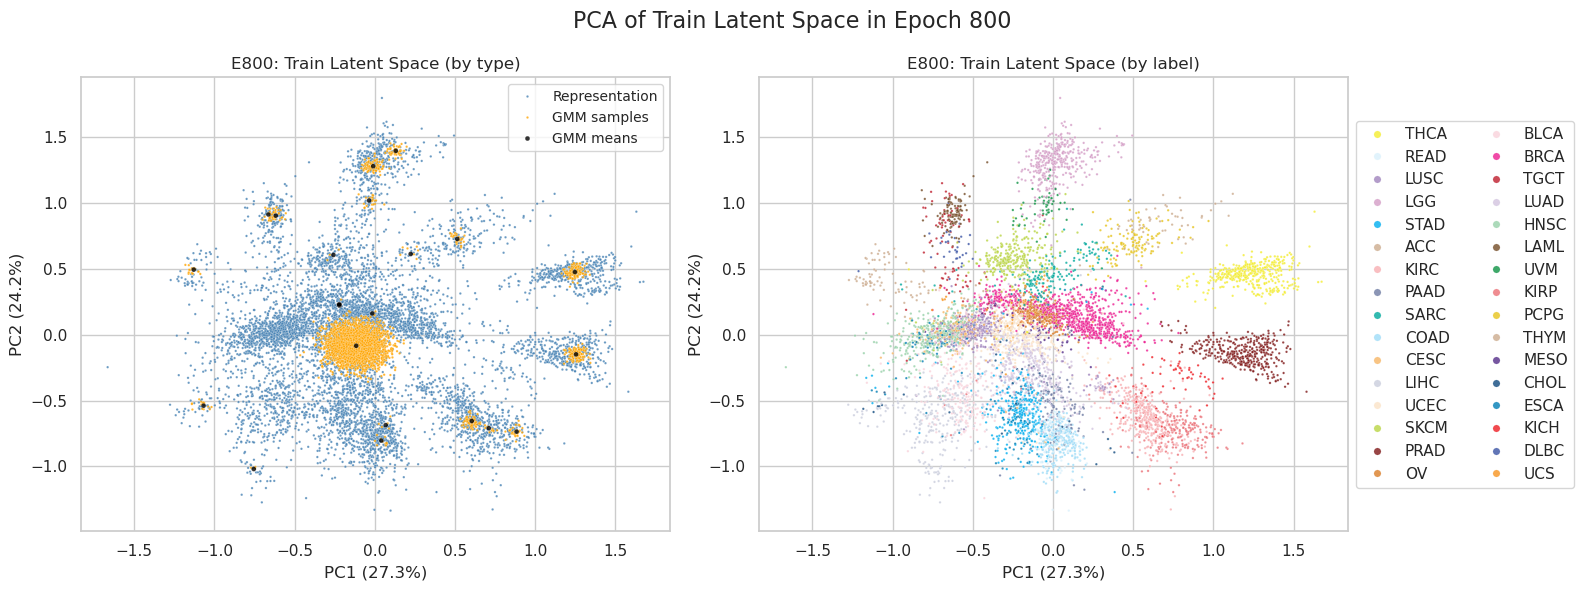

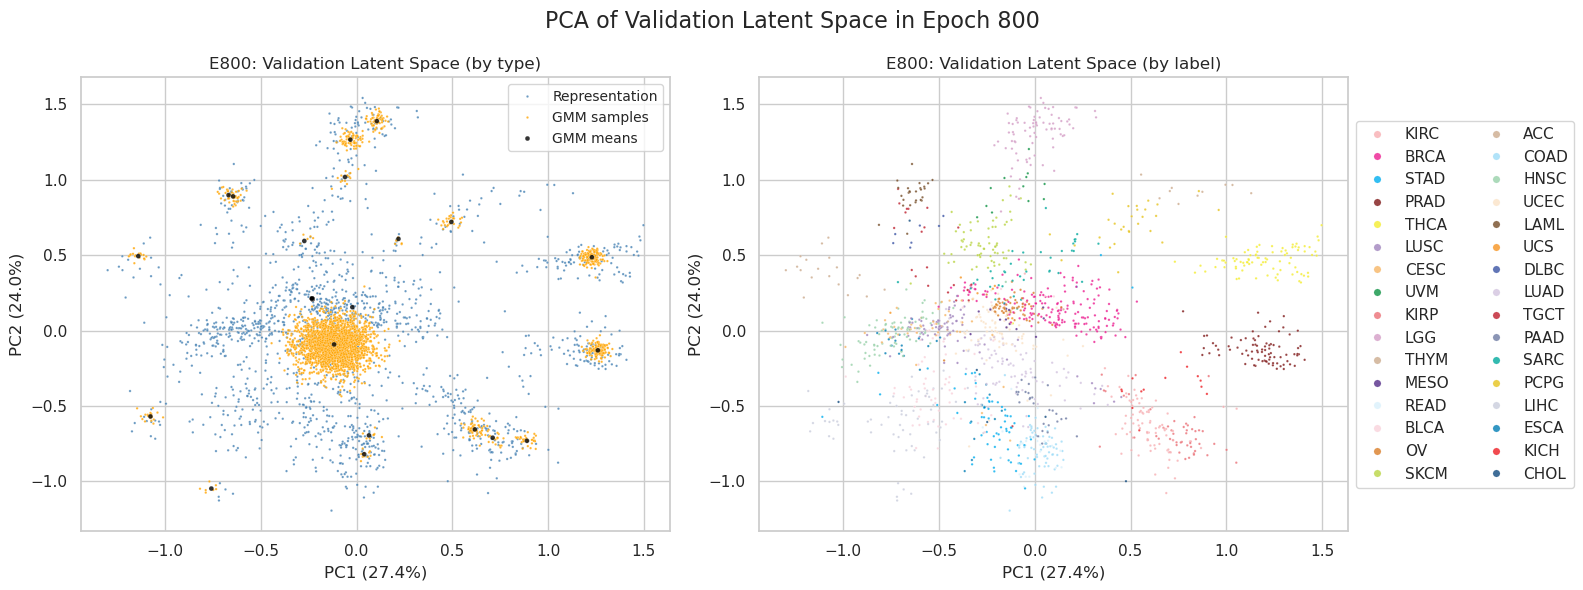

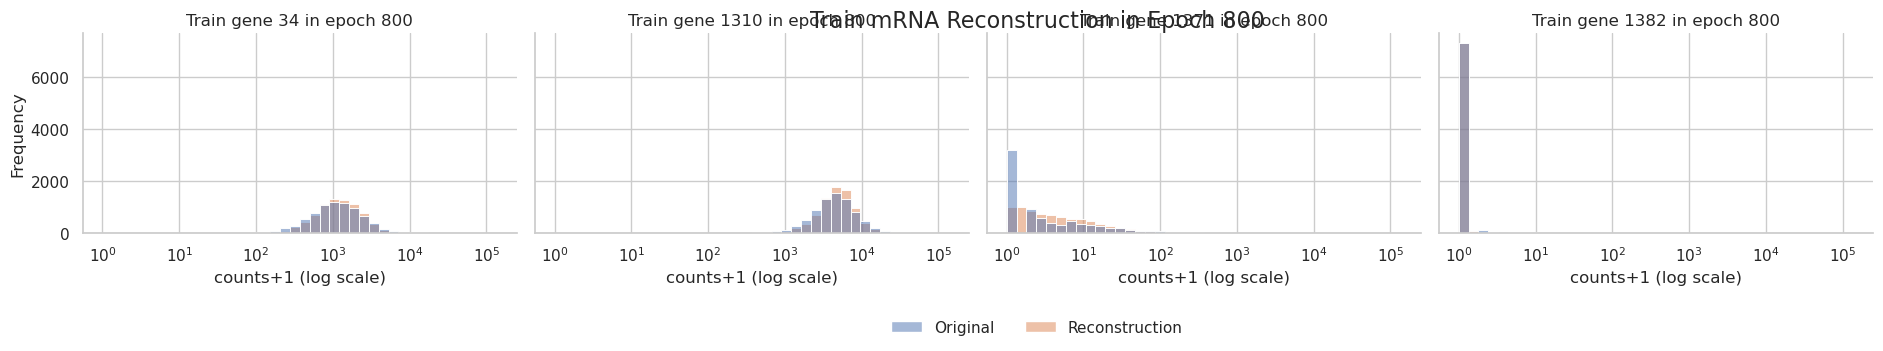

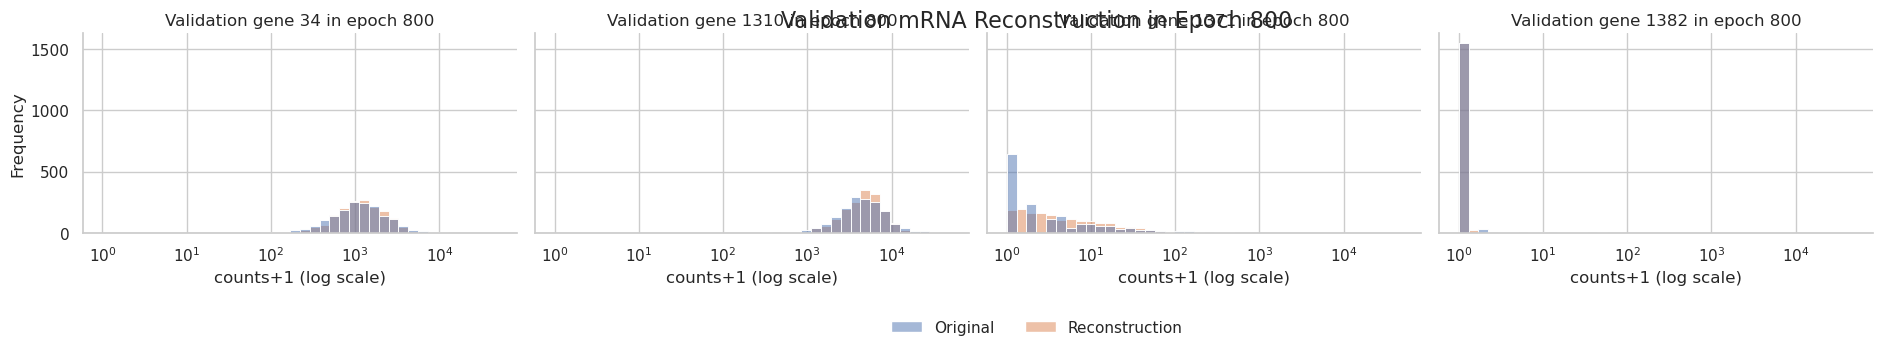

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 801/801 [38:25<00:00,  2.88s/it]


In [29]:
loss_tab = train_dgd_mrna(
        dgd, train_loader, validation_loader, device,
        learning_rates=learning_rates, weight_decay=weight_decay, betas=betas, 
        nepochs=nepochs, pr=pr, plot=plot, reduction_type=reduction_type,
        sample_index=sample_index, wandb_log=False
    )

# Save Model

In [34]:
save = True

if save:
    # Set results paths
    loss_path = 'results/final_loss_mrna.pickle'
    dgd_path = 'results/final_dgd_mrna.pickle'
    
    torch.save(loss_tab, loss_path)
    torch.save(dgd, dgd_path)

# Plotting

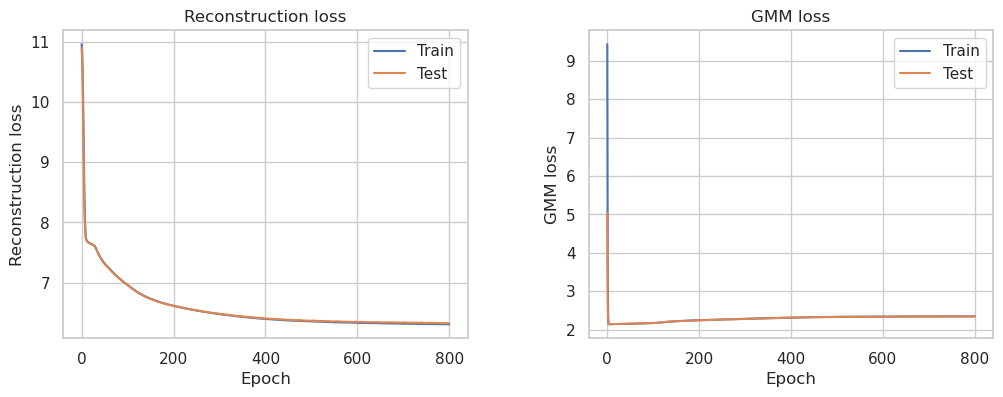

In [33]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(12, 4))
plt.subplots_adjust(wspace=0.3)

# First subplot for Reconstruction loss
plt.subplot(1, 2, 1)
sns.lineplot(x="epoch", y="train_recon", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_recon", data=loss_tab, label="Test")
plt.title("Reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")

# Second subplot for GMM loss
plt.subplot(1, 2, 2)
sns.lineplot(x="epoch", y="train_gmm", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_gmm", data=loss_tab, label="Test")
plt.title("GMM loss")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")

# Display the plots
plt.show()

# Simple Analysis

In [12]:
dgd = torch.load('results/final_dgd_mrna.pickle', map_location=torch.device('cpu'))
# dgd = torch.load('results/final_dgd_mirna.pickle')

In [13]:
def prepare_potential_reps(sample_list):
    return sample_list[0]

def learn_new_representation(dgd, 
                             data_loader,
                             test_epochs=50,
                             learning_rates=1e-2, 
                             weight_decay=0.,
                             betas=(0.5, 0.7),
                             reduction_type="sum",
                             resampling_type="mean"):
    """
    This function learns a new representation layer for the DGD.
    The new representation layer is learned by sampling new points
    from the GMMs and finding the best fitting GMM for each sample.
    The new representation layer is then optimized to minimize the
    reconstruction loss of the DGD.
    """
    
    gmm_loss = True
    n_samples_new = len(data_loader.dataset)
    potential_reps = prepare_potential_reps([dgd.gmm.sample_new_points(resampling_type)])

    dgd.eval()
    X_data = dgd.decoder(potential_reps.to(device))

    rep_init_values = torch.zeros((n_samples_new, potential_reps.shape[-1]))

    for (data, lib, i) in tqdm(data_loader.dataset):
        loss = torch.empty(0).to(device)
        for X in X_data:
            recon_loss = dgd.decoder.loss(
                nn_output=X.to(device), 
                target=data.to(device), 
                scale=lib, 
                mod_id="single", 
                feature_ids=None, 
                reduction="sum", 
                type="mrna"
            )
            loss = torch.cat((loss, recon_loss.unsqueeze(0)))
        best_fit_ids = torch.argmin(loss, dim=-1).detach().cpu()
        rep_init_values[i, :] = potential_reps.clone()[best_fit_ids, :]

    Ntest=len(data_loader.dataset)
    new_rep = RepresentationLayer(n_rep=dgd.rep_dim, 
                                  n_sample=Ntest,
                                  value_init=rep_init_values).to(device)
    test_rep_optimizer = torch.optim.AdamW(new_rep.parameters(), lr=learning_rates, weight_decay=weight_decay, betas=betas)

    for epoch in tqdm(range(test_epochs)):
        test_rep_optimizer.zero_grad()
        for (data, lib, index) in data_loader:
            recon_loss, gmm_loss = dgd.forward_and_loss(
                z=new_rep(index),
                target=data.to(device),
                scale=lib.unsqueeze(1).to(device), 
                gmm_loss=gmm_loss,
                reduction=reduction_type,
                type="mrna"
            )
            loss = recon_loss + gmm_loss
            loss.backward()
        test_rep_optimizer.step()
    
    return new_rep 

In [14]:
new_rep = learn_new_representation(dgd, test_loader, learning_rates=1e-2, weight_decay=0., test_epochs=50)
dgd.test_rep = new_rep

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:24<00:00,  1.70s/it]


In [17]:
scaling = torch.mean(test_loader.dataset.data, axis=1)
recon = dgd.forward(dgd.test_rep()) 
recon = recon * scaling.unsqueeze(1).to(device)
data = test_loader.dataset.data

In [18]:
X = recon.detach().cpu()
y = data.detach().cpu()

cancer_type = test_loader.dataset.label
color = test_loader.dataset.color
palette = dict(zip(cancer_type, color))

In [19]:
dgd

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=20, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
    )
    (out_module): NB_Module(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=19741, bias=True)
      )
    )
  )
  (gmm): GaussianMixture()
  (train_rep): RepresentationLayer()
  (val_rep): RepresentationLayer()
  (test_rep): RepresentationLayer()
)

In [18]:
mrna_column = pd.Series(train_mrna.columns[:-4])

def _add_columns(X, y, data_loader):
    X = X.assign(tissue=data_loader.dataset.tissue_type)
    X = X.assign(sample=data_loader.dataset.sample_type)
    X = X.assign(color=data_loader.dataset.color)
    X = X.assign(cancer_type=data_loader.dataset.label)
    
    y = y.assign(tissue=data_loader.dataset.tissue_type)
    y = y.assign(sample=data_loader.dataset.sample_type)
    y = y.assign(color=data_loader.dataset.color)
    y = y.assign(cancer_type=data_loader.dataset.label)
    return X, y

def _get_data_prediction(dgd, data_loader, mirna_column_name, dataset="train"):
    with torch.inference_mode():
        scaling = torch.mean(data_loader.dataset.data, axis=1)
        if dataset == "train":
            X = dgd.forward(dgd.train_rep()) 
        elif dataset == "val":
            X = dgd.forward(dgd.val_rep()) 
        elif dataset == "test":
            X = dgd.forward(dgd.test_rep()) 
        X = X * scaling.unsqueeze(1).to(device)
        X = X.detach().cpu().numpy()
        X = pd.DataFrame(X, columns=mirna_column_name)

        y = data_loader.dataset.data
        y = y.detach().cpu().numpy()
        y = pd.DataFrame(y, columns=mirna_column_name)
        
        X, y = _add_columns(X, y, data_loader)
    return X, y

def _get_data_pred_from_rep(dgd, test_rep, data_loader, mirna_column_name):
    with torch.inference_mode():
        scaling = torch.mean(data_loader.dataset.data, axis=1)
        X = dgd.forward(test_rep.z) 
        X = X * scaling.unsqueeze(1).to(device)
        X = X.detach().cpu().numpy()
        X = pd.DataFrame(X, columns=mirna_column_name)

        y = data_loader.dataset.data
        y = y.detach().cpu().numpy()
        y = pd.DataFrame(y, columns=mirna_column_name)
        
        X, y = _add_columns(X, y, data_loader)
    return X, y
    
def generate_analysis_data(dgd, train_loader, validation_loader, test_loader, mirna_column_name, subset=False, dataset="test"):
    if subset:
        if dataset == "train":
            X_train, y_train = _get_data_prediction(dgd, train_loader, mirna_column_name, dataset="train")
            train = pd.DataFrame(
                data={
                    'X': X_train[subset], 
                    'y': y_train[subset],
                    'cancer_type': train_loader.dataset.label,
                    'tissue': train_loader.dataset.tissue_type,
                    'color': train_loader.dataset.color
                }
            )
            return train
        elif dataset == "val":
            X_val, y_val = _get_data_prediction(dgd, validation_loader, mirna_column_name, dataset="val")
            val = pd.DataFrame(
                data={
                    'X': X_val[subset], 
                    'y': y_val[subset],
                    'cancer_type': validation_loader.dataset.label,
                    'tissue': validation_loader.dataset.tissue_type,
                    'color': validation_loader.dataset.color
                }
            )
            return val
        elif dataset == "test":
            X_test, y_test = _get_data_prediction(dgd, test_loader, mirna_column_name, dataset="test")
            test = pd.DataFrame(
                data={
                    'X': X_test[subset], 
                    'y': y_test[subset],
                    'cancer_type': test_loader.dataset.label,
                    'tissue': test_loader.dataset.tissue_type,
                    'color': test_loader.dataset.color
                }
            )
            return test
    else:
        X_train, y_train = _get_data_prediction(dgd, train_loader, mirna_column_name, dataset="train")
        X_val, y_val = _get_data_prediction(dgd, validation_loader, mirna_column_name, dataset="val")
        X_test, y_test = _get_data_prediction(dgd, test_loader, mirna_column_name, dataset="test")
        
    return X_train, y_train, X_val, y_val, X_test, y_test

def get_mirna_data(dgd, data_loader, subset, mirna_column_name=mrna_column, dataset="test"):
    return generate_analysis_data(dgd, *data_loader, mirna_column_name, subset=subset, dataset=dataset)

X_train, y_train, X_val, y_val, X_test, y_test = generate_analysis_data(dgd, train_loader, validation_loader, test_loader, mrna_column)

In [21]:
from scipy import stats

def calculate_corr(X, y, axis=0):
    spearman_corr = []
    pearson_corr = []
    spearman_pval = []
    pearson_pval = []
    r2 = []
    r2_pval = []
    X = X.iloc[:,:-4]
    y = y.iloc[:,:-4]
    
    if axis == 0:
        for i in range(y.shape[1]):
            # Calculate Spearman correlation coefficient
            spearman, spearman_p = stats.spearmanr(X.iloc[:, i], y.iloc[:, i])
            pearson, pearson_p = stats.pearsonr(X.iloc[:, i], y.iloc[:, i])
            _, _, r_value, r_p, _ = stats.linregress(X.iloc[:, i], y.iloc[:, i])
            
            spearman_corr.append(spearman)
            pearson_corr.append(pearson)
            r2.append(r_value**2)
            spearman_pval.append(spearman_p)
            pearson_pval.append(pearson_p)
            r2_pval.append(r_p)
        
        corr_data = pd.DataFrame(
            data={  
                'pearson': pearson_corr,
                'spearman': spearman_corr,
                'r2': r2,
                'pearson_p': pearson_pval,
                'spearman_p': spearman_pval,
                'r2_p': r2_pval,
                'mirna': X.columns
            },
            index=np.arange(0, len(X.columns))
        )
    elif axis == 1:
        for i in range(y.shape[0]):
            # Calculate Spearman correlation coefficient
            spearman, spearman_p = stats.spearmanr(X.iloc[i, :], y.iloc[i, :])
            pearson, pearson_p = stats.pearsonr(X.iloc[i, :], y.iloc[i, :])
            _, _, r_value, r_p, _ = stats.linregress(X.iloc[i, :], y.iloc[i, :])
            
            spearman_corr.append(spearman)
            pearson_corr.append(pearson)
            r2.append(r_value**2)
            spearman_pval.append(spearman_p)
            pearson_pval.append(pearson_p)
            r2_pval.append(r_p)
        
        corr_data = pd.DataFrame(
            data={  
                'pearson': pearson_corr,
                'spearman': spearman_corr,
                'r2': r2,
                'pearson_p': pearson_pval,
                'spearman_p': spearman_pval,
                'r2_p': r2_pval,
                'mirna': X.index[:-4]
            },
            index=np.arange(0, len(X.index))
        )
    else:
        raise ValueError("Axis must be 0 (columns) or 1 (rows).")
    
    return corr_data.sort_values(by='pearson', ascending=False, ignore_index=True)

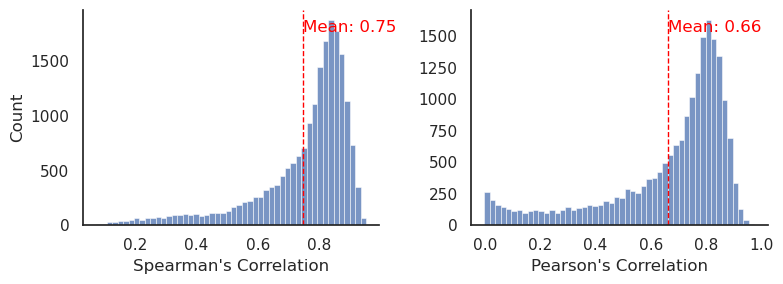

In [29]:
corr_data = calculate_corr(X_test, y_test, axis=0)

sns.set_theme(style="white")
sns.set_style("white")
fig = plt.figure(figsize=(8,3))

plt.subplot(1, 2, 1)
sns.histplot(data=corr_data, x='spearman', bins=50)
# plt.title("Spearman's Correlation")
plt.xlabel("Spearman's Correlation")
mean_spearman = corr_data['spearman'].mean()
plt.axvline(mean_spearman, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_spearman, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_spearman:.2f}', color='red')

plt.subplot(1,2,2)
sns.histplot(data=corr_data, x='pearson', bins=50)
# plt.title("Pearson's Correlation")
plt.xlabel("Pearson's Correlation")
plt.ylabel("")
mean_pearson = corr_data['pearson'].mean()
plt.axvline(mean_pearson, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_pearson, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_pearson:.2f}', color='red')

# Add the main title to the figure
# fig.suptitle("miRNA Correlation Distribution", fontsize=24)

# Display the plots
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join("plots", "corr gene feature.svg"))
plt.show()

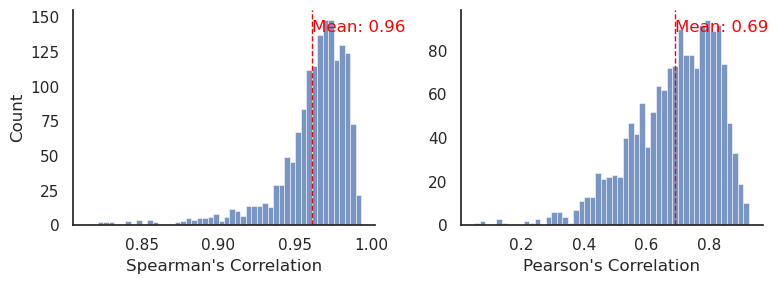

In [28]:
corr_data = calculate_corr(X_test, y_test, axis=1)

sns.set_theme(style="white")
sns.set_style("white")
fig = plt.figure(figsize=(8,3))

plt.subplot(1, 2, 1)
sns.histplot(data=corr_data, x='spearman', bins=50)
# plt.title("Spearman's Correlation")
plt.xlabel("Spearman's Correlation")
mean_spearman = corr_data['spearman'].mean()
plt.axvline(mean_spearman, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_spearman, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_spearman:.2f}', color='red')

plt.subplot(1,2,2)
sns.histplot(data=corr_data, x='pearson', bins=50)
# plt.title("Pearson's Correlation")
plt.xlabel("Pearson's Correlation")
plt.ylabel("")
mean_pearson = corr_data['pearson'].mean()
plt.axvline(mean_pearson, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_pearson, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_pearson:.2f}', color='red')

# Add the main title to the figure
# fig.suptitle("miRNA Correlation Distribution", fontsize=24)

# Display the plots
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join("plots", "corr gene samples.svg"))
plt.show()

In [24]:
print((corr_data['spearman'] > 0.75).sum())
print((corr_data['pearson'] > 0.75).sum())

13025
9801


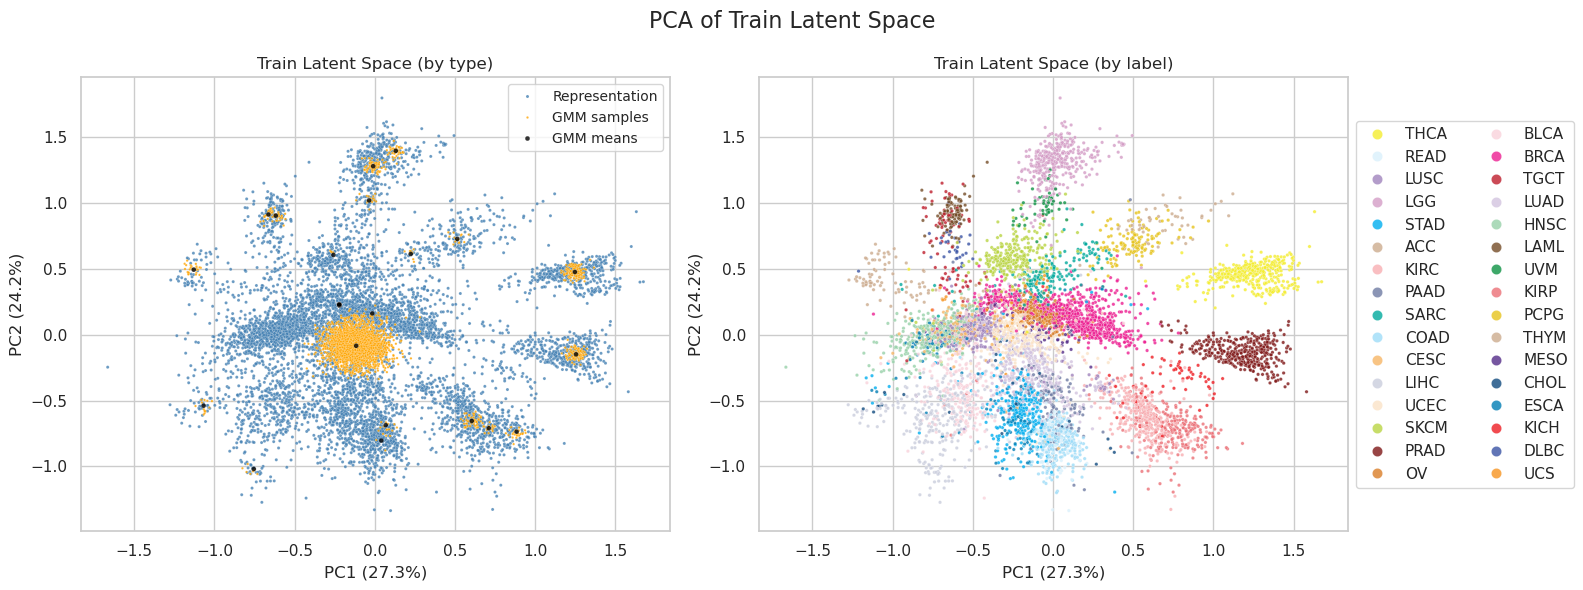

In [42]:
from sklearn.decomposition import PCA

def plot_latent_space(rep, means, samples, gmm, labels, color_mapping, dataset="Train", 
                      savedir="plots", filename=None):
    # get PCA
    pca = PCA(n_components=2)
    pca.fit(rep)
    rep_pca = pca.transform(rep)
    means_pca = pca.transform(means)
    samples_pca = pca.transform(samples)
    df = pd.DataFrame(rep_pca, columns=["PC1", "PC2"])
    df["type"] = "Representation"
    df["label"] = labels
    df_temp = pd.DataFrame(samples_pca, columns=["PC1", "PC2"])
    df_temp["type"] = "GMM samples"
    df = pd.concat([df,df_temp])
    df_temp = pd.DataFrame(means_pca, columns=["PC1", "PC2"])
    df_temp["type"] = "GMM means"
    df = pd.concat([df,df_temp])

    # make a figure with 2 subplots
    # set a small text size for figures
    plt.rcParams.update({'font.size': 6})
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    # add spacing between subplots
    fig.subplots_adjust(wspace=0.2, top=0.9)

    # first plot: representations, means and samples
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="type", size="type", sizes=[5,3,12], alpha=0.8, ax=ax[0], palette=["steelblue","orange","black"])
    ax[0].set_title(str(dataset)+" Latent Space (by type)")
    ax[0].legend(loc='upper right', fontsize='small')
    
    # add explained variance to x-label and y-label for first plot
    ax[0].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")

    # second plot: representations by label
    sns.scatterplot(data=df[df["type"] == "Representation"], x="PC1", y="PC2", hue="label", s=6, alpha=0.8, ax=ax[1], palette=color_mapping)
    ax[1].set_title(str(dataset)+" Latent Space (by label)")
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, markerscale=3)
    
    # add explained variance to x-label and y-label for second plot
    ax[1].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax[1].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")


    # plot
    plt.suptitle(f'PCA of {dataset} Latent Space', fontsize=16)
    plt.tight_layout()
    
    if filename:
        plt.savefig(os.path.join(savedir, filename))
    plt.show()

plot_latent_space(*dgd.get_latent_space_values("train",3000), dgd.gmm, train_loader.dataset.label, color_mapping, dataset="Train",
                 filename="PCA of gene test latent space.pdf")